*Note*: Since we had three people in the group + issues pushing to github even without data and the plotting, we decided to each make our own functions and plots to filter by using zscore to make sure we get the same threshold z-score (which came out to -0.12). <br> 


In [81]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import uncertainties as unc
from scipy import stats
from scipy.stats import norm 
from scipy.stats import zscore
import scipy.constants as const
from tabulate import tabulate
import math
from matplotlib import cm
import matplotlib.cm as cm
import seaborn as sns
from scipy.optimize import minimize
import numpy as np
from pyuvdata import UVData
%matplotlib inline

### Read in HERA data

In [83]:
# Read in data and print shape as in lab 6
path_to_data_file = './Hera/'
uv = UVData()
uv.read('./zen.2459122.34011.mini.sum (2).uvh5')
data = uv.data_array
freqs = uv.freq_array[0]*1e-6
print('This data array has shape:')
print('(# baselines*times, # spectral windows, # frequencies, # polarizations)')
print(np.shape(data))
print(data.ndim)

This data array has shape:
(# baselines*times, # spectral windows, # frequencies, # polarizations)
(13320, 1, 1536, 1)
4


### Function to Find Amplitude Diffs

Define the function  `amplitude_diff` that takes in the visibility data (uv), then:
1. Retrieves a list of unique baselines, `baseline_pairs`, using method `UVData.get_baseline_nums()`. 
2. Initializes an empty dictionary `amp_diffs` to store amplitude differences for each baseline.
3. Iterates over unique baselines (unique pair of antennas). For each iteration:

    a. Pulls the visibility data for the baseline, `data_apair`,  using method `UVData.get_data(baseline)`. 
    This is a 2D array of time steps x freq.
    
    b. Calculates the amplitudes of the complex visibility data, `amplitudes`, using `np.abs()`.
    
    c. Calculates the amplitude difference, `difference`, between adjacent time slices using `np.diff()` along the time axis [0].
    
    d. Stores the amplitude differences in the dictionary `amp_diffs[baseline]`.
4. Returns the full dictionary of differences in `amp_diffs` with baseline IDs as keys.
    


In [85]:
def amplitude_diff(uvdata):
    # get_baseline_nums() Returns 1D darray of int-Array of unique baselines with data associated with them. Shape (666,)
    baseline_pairs = uvdata.get_baseline_nums()
    # Dictionary to store amplitude diffs
    amp_diffs = {} 
    

    # Iterate over baselines to get amplitude diffs for every unique baseline/antenna pair
    for baseline in baseline_pairs:
        data_apair = uvdata.get_data(baseline)
        amplitudes = np.abs(data_apair)
        difference = np.abs(np.diff(amplitudes, axis=0))
        amp_diffs[baseline] = difference  
    return amp_diffs

### Define Function to filter through each pairing and plot freq. vs. avg amp before and after

Define the function `filter` that takes in the visibility data (uv), then:
1. Retrieves a list of unique baselines, `baseline_pairs`, using method `UVData.get_baseline_nums()`.
2. Calls the function `amplitude_diff` to get dictionary of amplitude differences for each baseline.`amplitude_differences`.
3. Initializes an empty dictionary `filtered_data` to store filtered visibility data for each baseline.

4. Iterate over each baseline. For each iteration; `baseline in baseline_pairs`:

    a. Pull corresponding antenna pair numbers using `baseline_to_antnums(baseline)`. `antenna1, antenna2`.
    
    b. Retrieve visibility data for the pair using `get_data(baseline)`. `data_apair`. 
    
    c. Find the mean of the baseline's amplitude difference data in `amplitude_differences` before filtering for each frequency. `avg_diff_before`.
    
    d. Calculate z-score of `avg_diff_before` array. (Also included: plot distribution of z-scores and ran once to get threshold values of -.010:-0.015 to test. Commented out after to reduce run time.)
    
    e. Identifies indices to reject based on defined `threshold`. `rejected_indices`.
    
    f. Filter frequency and amplitude data by deleting rejected indices in all frequencies,`freq`, of each. `freqs_filtered` and `amplitudes_filtered`.
    
    g. Store filtered amplitude data in dictionary `filtered_data[baseline]`.
    
    h. Calculate the filtered amplitude difference data and mean. `avg_diff_after`.
    
    i. Print shapes of frequency and amplitude arrays before and after filtering to see how data is cut.
    
    i. Plot 2 plots each with filtered and unfiltered data to evaluate filtering: Frequency vs. avg. Amplitude and Frequency vs. avg. Differential Amplitude.

5. Returns `filtered_data`, which contains filtered visiblility data for all unique baselines.


In [88]:
def filter(data):
    # Get unique baselines with visibilities using method get_baseline_nums().
    baseline_pairs = data.get_baseline_nums() # 1D int array of unique baselines that have associated data. (666,)
    
    # Call amplitude difference function to get array with amplitude differences of adjacent time slices for each baseline
    amplitude_differences = amplitude_diff(data) 
    
    # Initialize dictionary to store filtered data for each baseline iteration/antenna pair
    filtered_data = {} 
    
    # Iterate through each unique baseline/antenna pair to determine threshold then filter data and plot before and after 
    for baseline in baseline_pairs:
        # Get antenna numbers for current baseline
        antenna1, antenna2 = data.baseline_to_antnums(baseline)        
        # Get visibility data for the baseline/pair 
        data_pair = data.get_data(baseline) # 2D complex array
        amplitudes = np.abs(data_pair)
        # Calculate avg. amplitude diff for baseline BEFORE filtering
        avg_diff_before = np.mean(amplitude_differences[baseline], axis=0) # 1D array (1536,)
        # Calculate z score of mean amplitude diff data. Plot z dist. once for threshold guesses then comment out.
        z = zscore(avg_diff_before)
        ##### Plot z score dist
        ##### plt.hist(z, bins=10, range=(-1,5))
        ##### plt.title(f"z-score distribution for baseline ({antenna1}, {antenna2}).")
        ##### plt.xlabel("z-score")
        ##### plt.ylabel("count")
        ##### plt.show()
        # Define threshold for z-score to use for filtering
        threshold = -0.012
        # Filter freqs and corresponding amplitudes using indices where z>threshold in frequency array and deleting rejects
        rejected_indices = np.where(z > threshold)[0] # 1D array of locations of frequencies to remove 
        amplitudes_filtered = np.delete(np.abs(data_pair), rejected_indices, axis=1) # 2D array of filtered visibility data
        freqs = data.freq_array[0]*1e-6 # Original frequencies array
        freqs_filtered = np.delete(freqs, rejected_indices) # 1D filtered frequencies array
        # Store filtered vis data in dictionary filtered_data for current baseline 
        filtered_data[baseline] = amplitudes_filtered
        # Calculate avg. amplitude differences now for filtered visibility data
        avg_diff_after = np.mean(np.abs(np.diff(np.abs(amplitudes_filtered), axis=0)), axis=0) 
        
        # Print shapes before and after filtering to see how data is cut.
        print("rejected", rejected_indices.shape)
        print("freqs shape:", freqs.shape)
        print("freqs_filtered shape:", freqs_filtered.shape)
        print("amplitudes_filtered shape:", amplitudes_filtered.shape)
        print("Threshold for baseline:", threshold)
        
        # plotting before and after filtering. Frequency vs. avg. amplitude of the difference in visibility between each
        # pair of adjacent time slices
        fig, axs = plt.subplots(2, 1, figsize=(10,10))
        
        axs[0].plot(freqs, avg_diff_before, alpha=0.4, color='k', label=f"Baseline Pair ({antenna1}, {antenna2}) Before Filtering")
        axs[0].plot(freqs_filtered, avg_diff_after, alpha=0.2, color='r', label=f"Baseline Pair ({antenna1}, {antenna2}) After Filtering")
        axs[0].set_xlabel("Frequency [Mhz]")
        axs[0].set_ylabel("Average Differential Amplitude")
        axs[0].set_title(f"Frequency vs Avg. Differential Amplitude for Baseline Pair ({antenna1}, {antenna2})")
        axs[0].legend()
        
        
        # plotting before and after filtering. Frequency vs. avg. Amplitude 
        
        axs[1].plot(freqs, np.mean(np.abs(data_pair), axis=0), alpha=0.4, color='k', label=f"Baseline Pair ({antenna1}, {antenna2}) Before Filtering")
        axs[1].plot(freqs_filtered, np.mean(np.abs(amplitudes_filtered), axis=0), alpha=0.2, color='r', label=f"Baseline Pair ({antenna1}, {antenna2}) After Filtering")
        axs[1].set_xlabel("Frequency [Mhz]")
        axs[1].set_ylabel("Average Amplitude")
        axs[1].set_title(f"Frequency vs Avg. Amplitude for Baseline Pair ({antenna1}, {antenna2})")
        axs[1].legend()
        plt.show()      
        
        
        ### ADDITIONAL PLOTS COMMENTED OUT TO SAVE RUNTIME
        # Waterfall plot of filtered data
        # a_f = np.mean(np.abs(amplitudes_filtered), axis=0, keepdims=True)
        # fig, axs = plt.subplots(1,1,figsize=(8,4))
        # im = plt.imshow(a_f,aspect='auto')
        # cbar = fig.colorbar(im)
        # axs.set_ylabel('Time')
        # axs.set_xlabel('Frequency (MHz)')
        # axs.set_title('Waterfall Plot of Avg. Amplitude After Contamination Removal for Baseline Pair (1,2)')
        # xticks = [int(i) for i in np.linspace(0,len(freqs_filtered)-1,8)]
        # _ = axs.set_xticks(xticks)
        # xticklabels = np.around(freqs_filtered[xticks],0)
        # _ = axs.set_xticklabels(xticklabels)

        # Waterfall Plot before filtering
        # a_uf = np.mean(np.abs(data_pair), axis=0, keepdims=True)
        # fig, axs = plt.subplots(1,1,figsize=(8,4))
        # im = plt.imshow(a_uf,aspect='auto')
        # cbar = fig.colorbar(im)
        # freqs = uv.freq_array[0]*1e-6 #gets frequencies associated with each channel, in MHz
        # axs.set_ylabel('Time')
        # axs.set_xlabel('Frequency (MHz)')
        # axs.set_title('Waterfall Plot of Avg. Amplitude Before Contamination Removal for Baseline Pair (1,2)')
        # xticks = [int(i) for i in np.linspace(0,len(freqs)-1,8)]
        # _ = axs.set_xticks(xticks)
        # xticklabels = np.around(freqs[xticks],0)
        # _ = axs.set_xticklabels(xticklabels)
        
    return filtered_data

### Call Filtering Function for HERA Data, uv

rejected (239,)
freqs shape: (1536,)
freqs_filtered shape: (1297,)
amplitudes_filtered shape: (20, 1297)
Threshold for baseline: -0.012


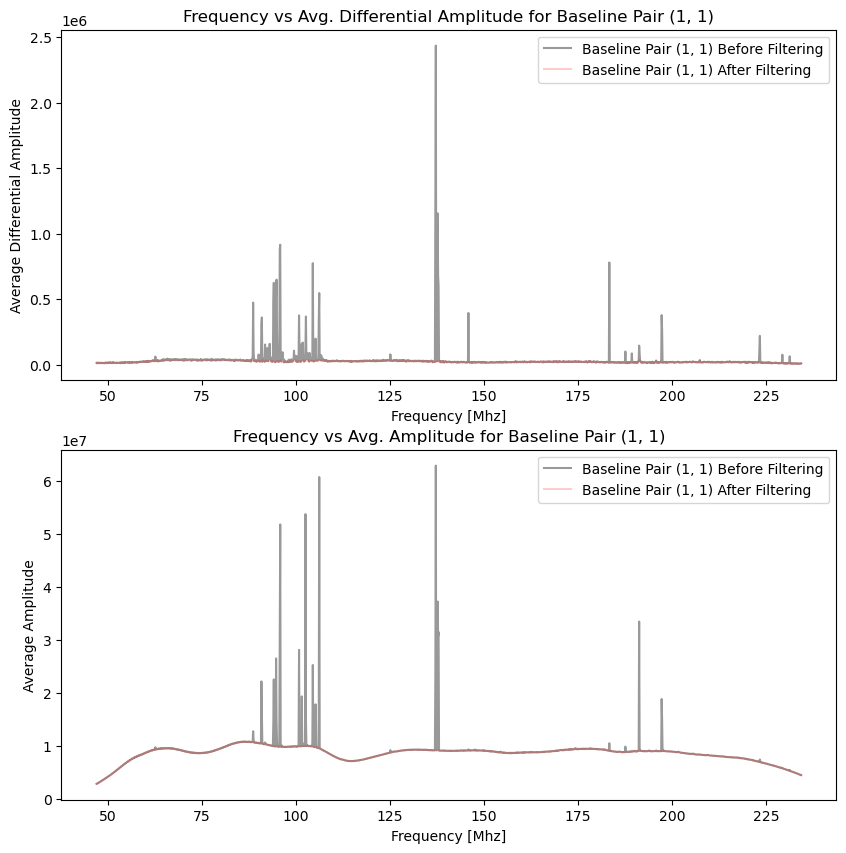

rejected (91,)
freqs shape: (1536,)
freqs_filtered shape: (1445,)
amplitudes_filtered shape: (20, 1445)
Threshold for baseline: -0.012


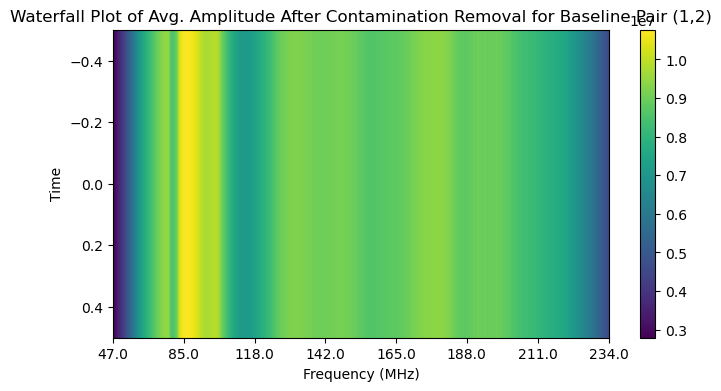

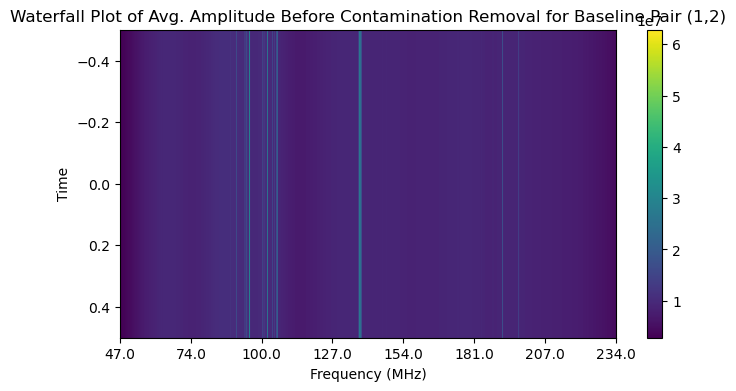

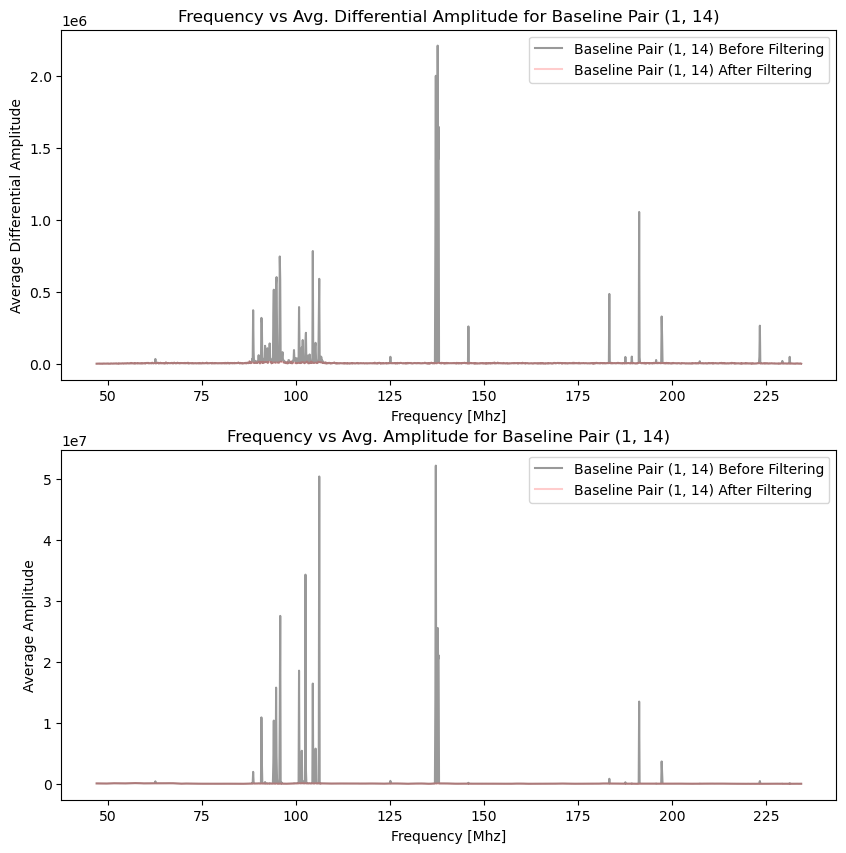

rejected (53,)
freqs shape: (1536,)
freqs_filtered shape: (1483,)
amplitudes_filtered shape: (20, 1483)
Threshold for baseline: -0.012


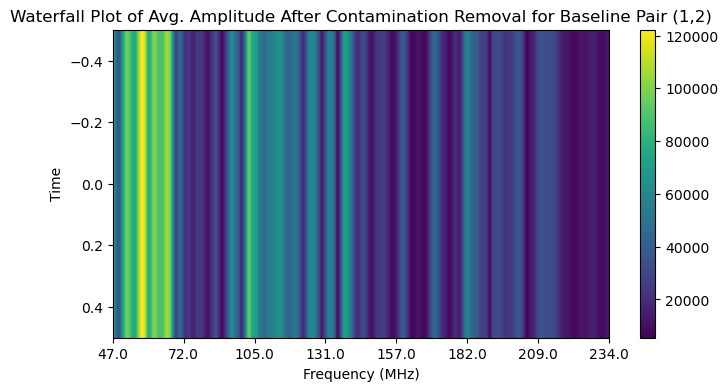

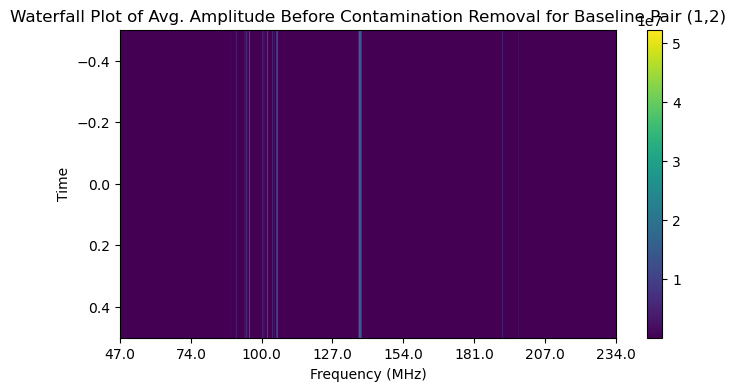

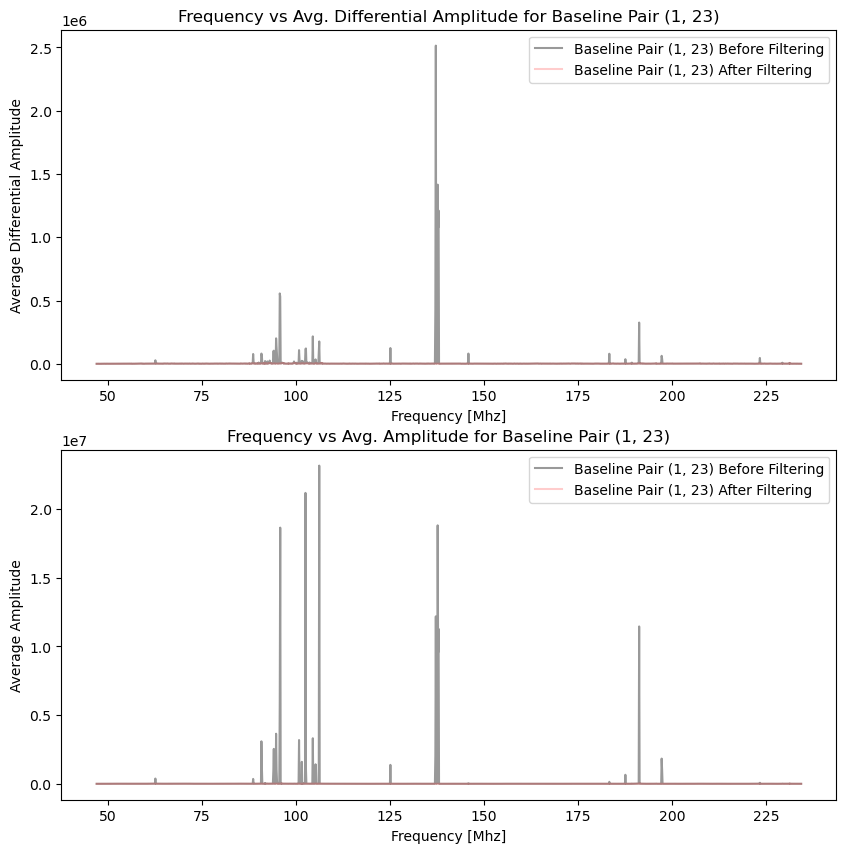

rejected (92,)
freqs shape: (1536,)
freqs_filtered shape: (1444,)
amplitudes_filtered shape: (20, 1444)
Threshold for baseline: -0.012


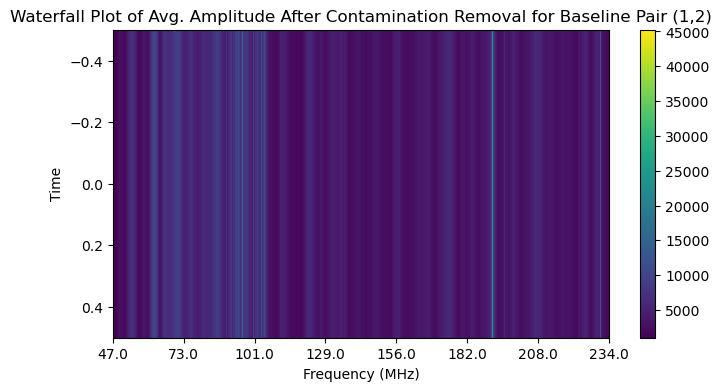

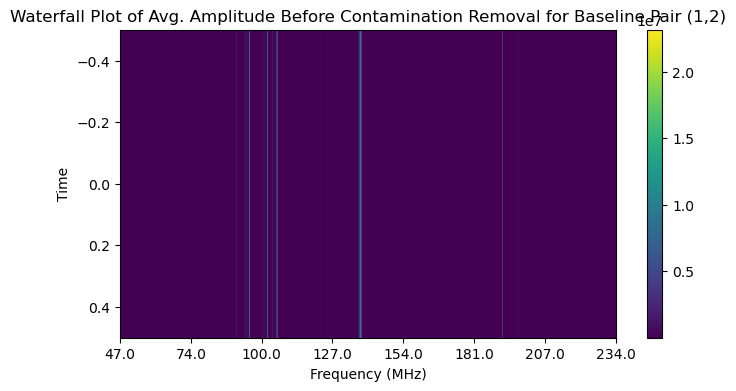

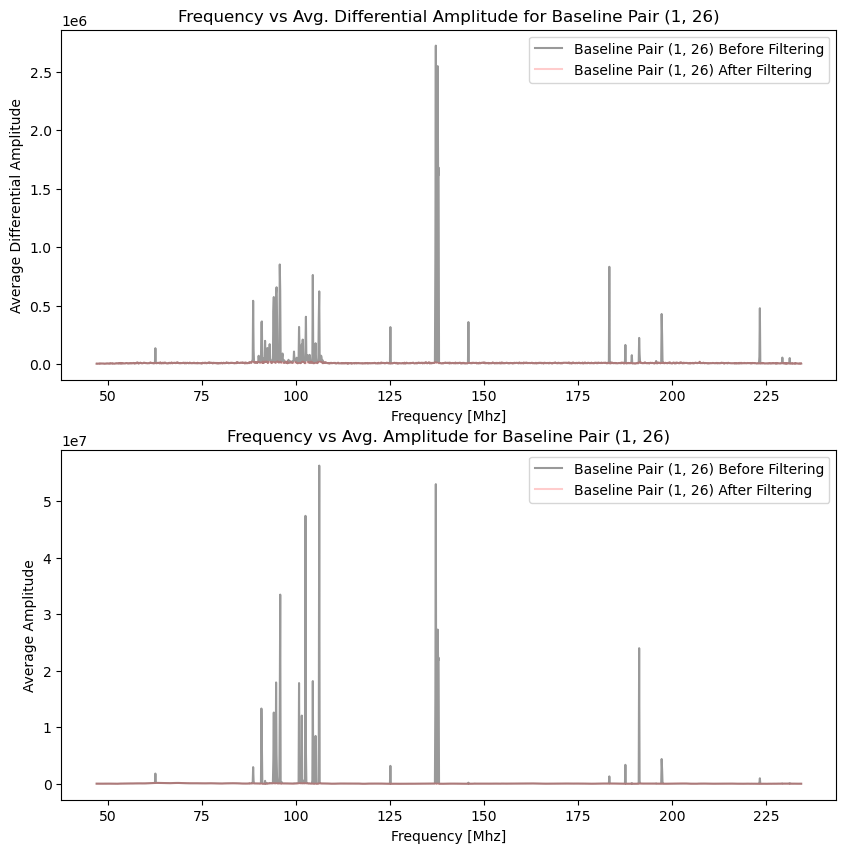

rejected (99,)
freqs shape: (1536,)
freqs_filtered shape: (1437,)
amplitudes_filtered shape: (20, 1437)
Threshold for baseline: -0.012


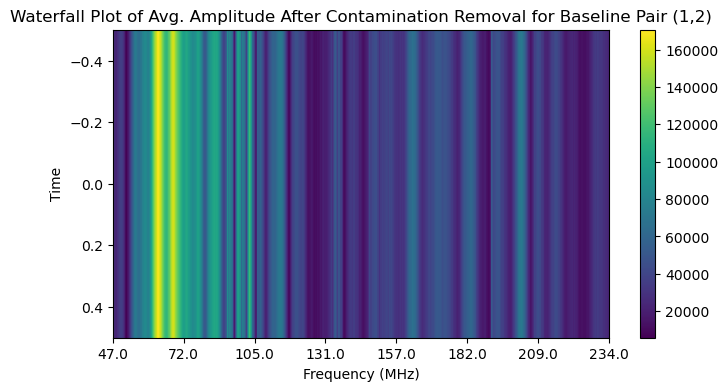

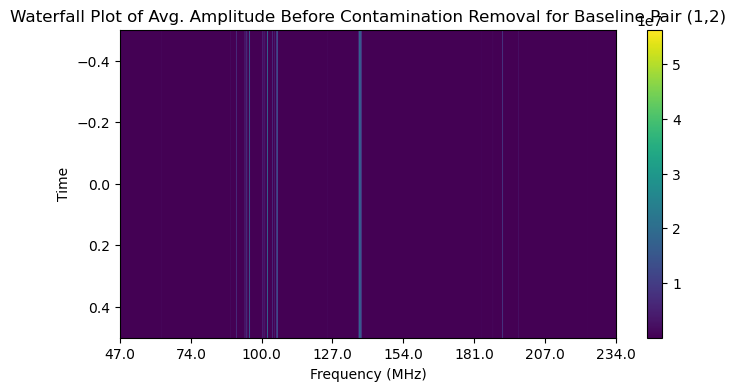

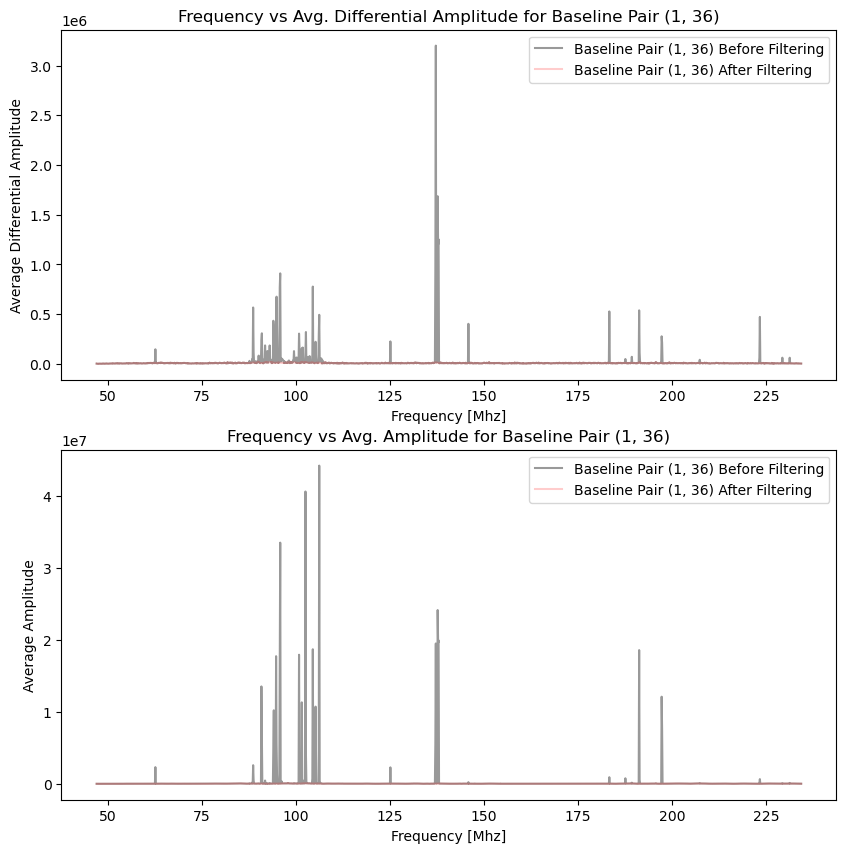

rejected (104,)
freqs shape: (1536,)
freqs_filtered shape: (1432,)
amplitudes_filtered shape: (20, 1432)
Threshold for baseline: -0.012


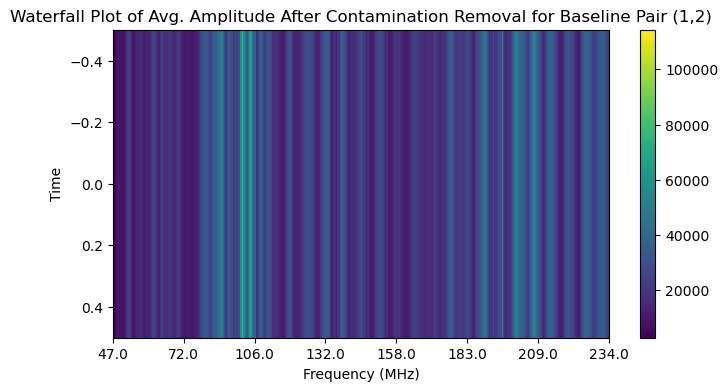

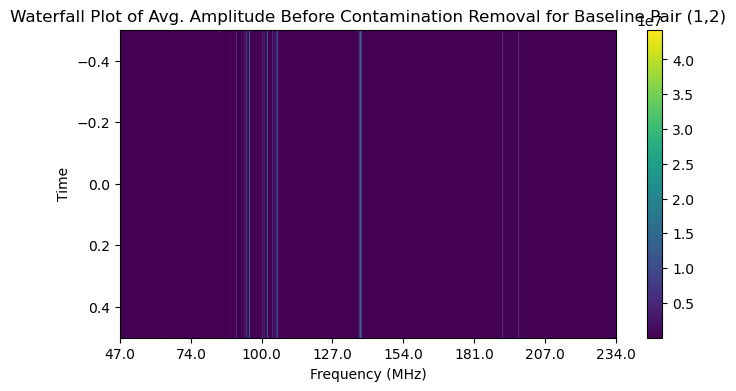

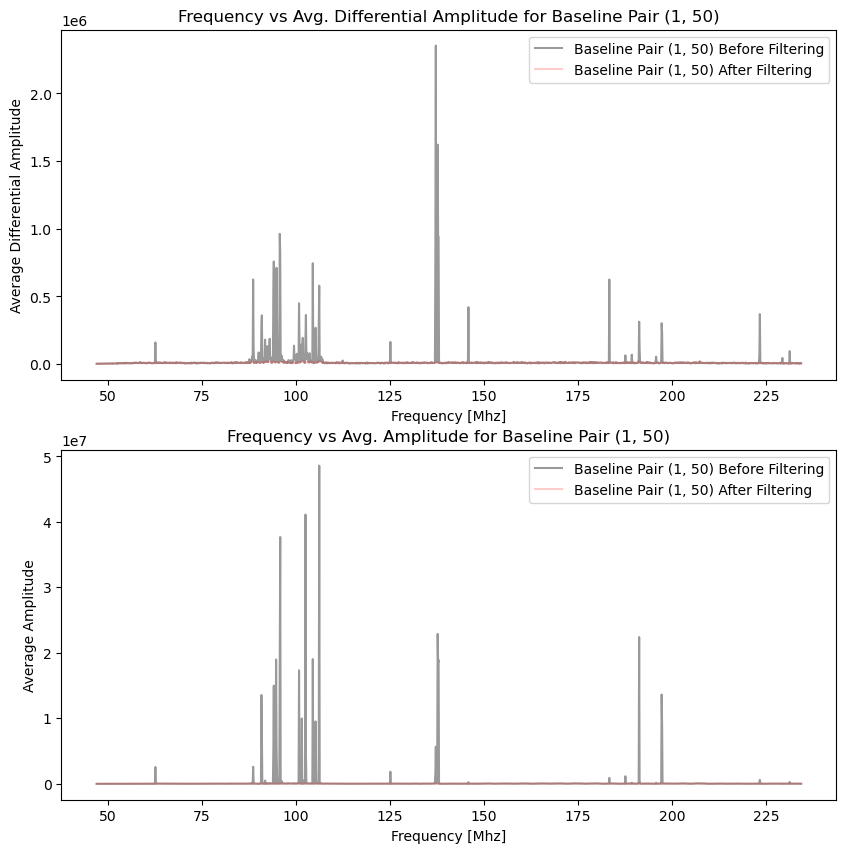

rejected (96,)
freqs shape: (1536,)
freqs_filtered shape: (1440,)
amplitudes_filtered shape: (20, 1440)
Threshold for baseline: -0.012


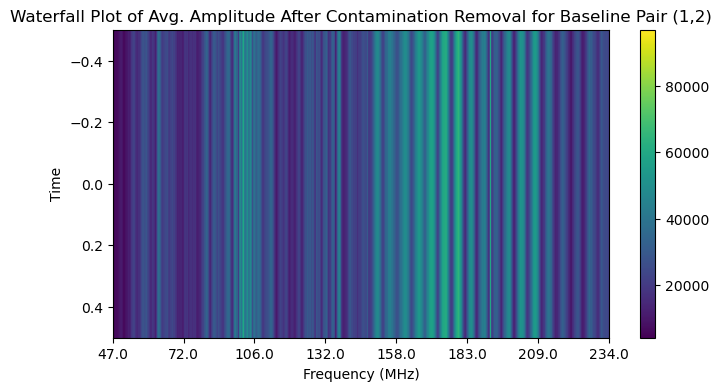

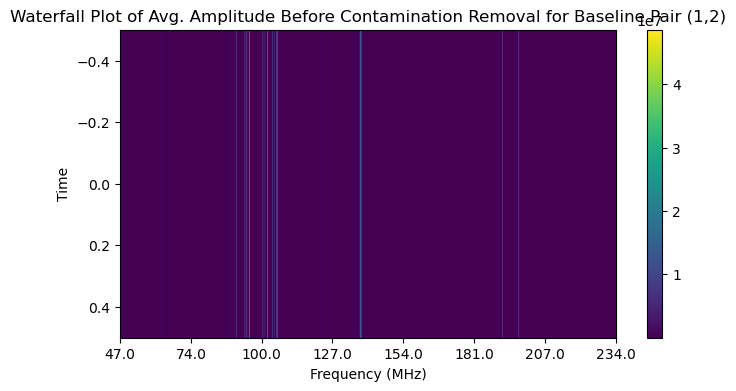

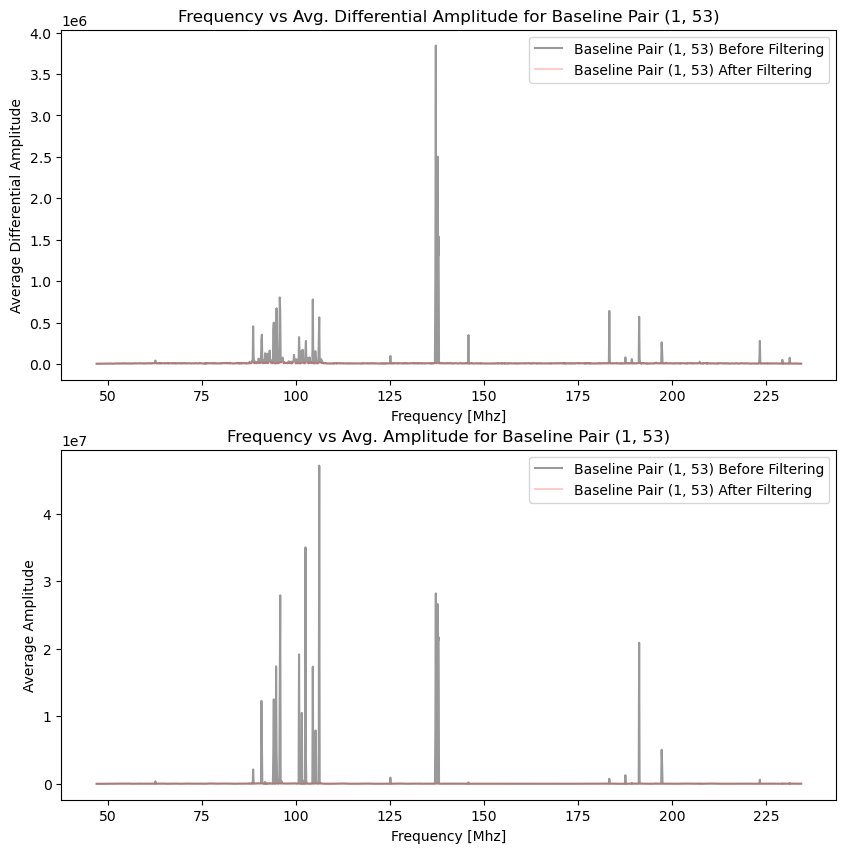

rejected (93,)
freqs shape: (1536,)
freqs_filtered shape: (1443,)
amplitudes_filtered shape: (20, 1443)
Threshold for baseline: -0.012


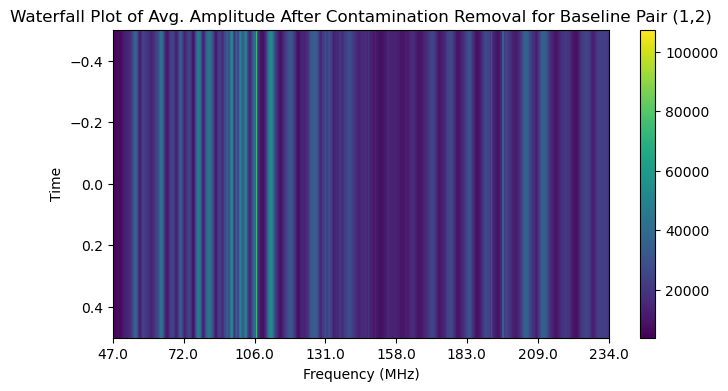

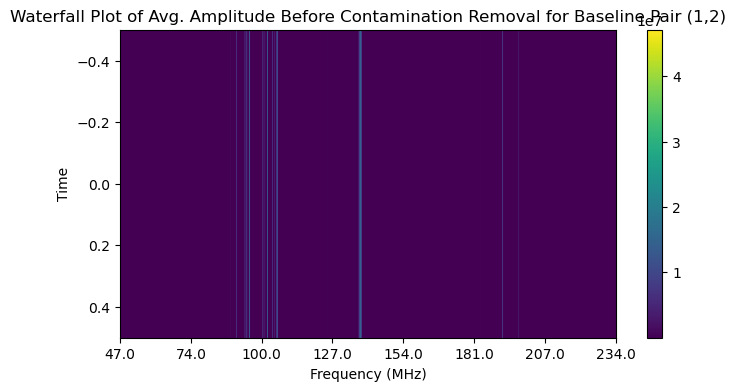

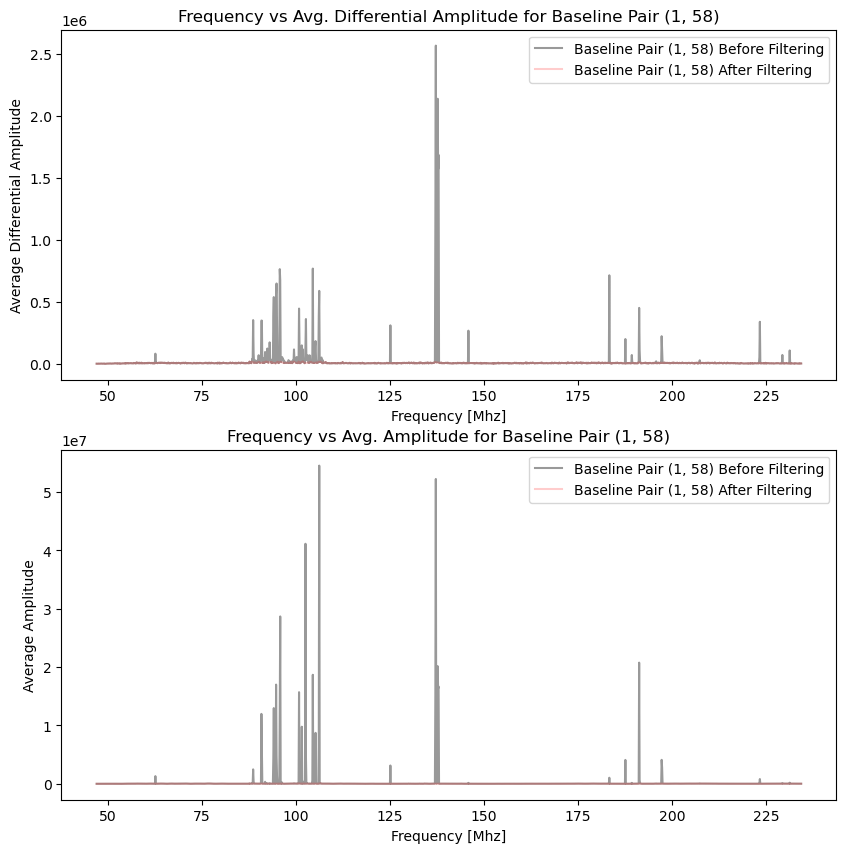

rejected (94,)
freqs shape: (1536,)
freqs_filtered shape: (1442,)
amplitudes_filtered shape: (20, 1442)
Threshold for baseline: -0.012


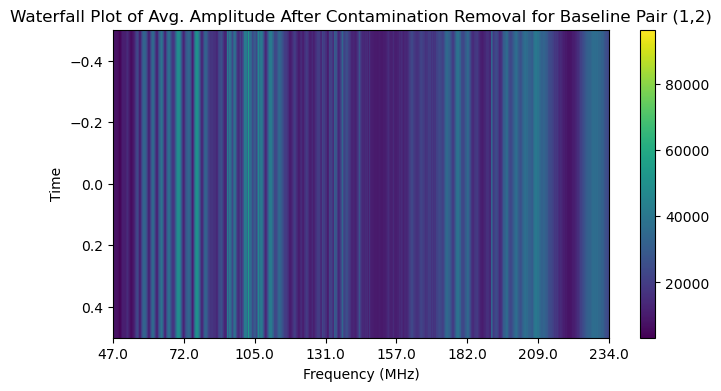

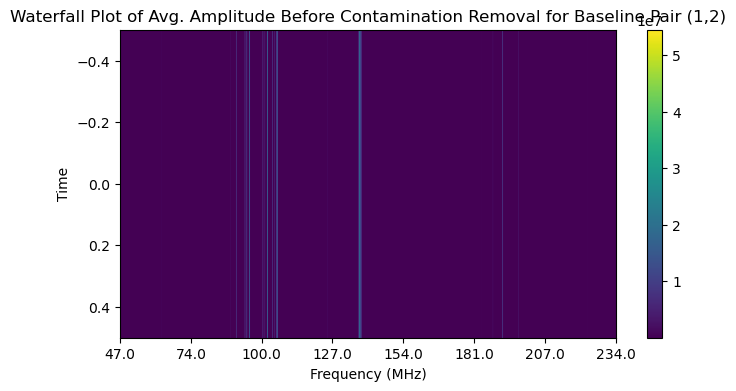

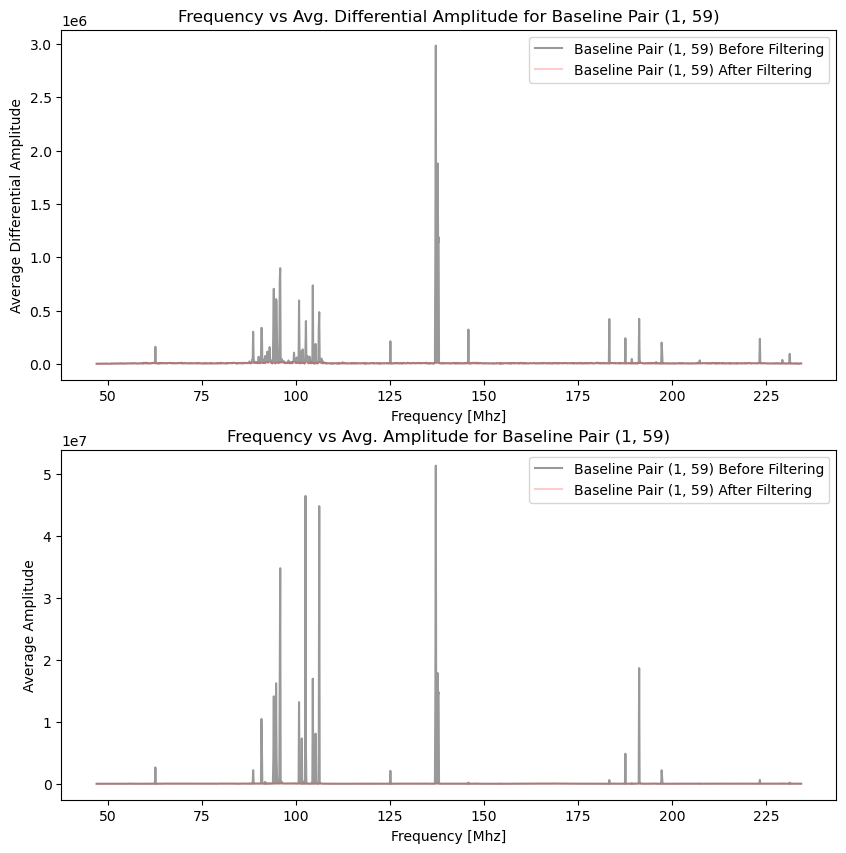

rejected (504,)
freqs shape: (1536,)
freqs_filtered shape: (1032,)
amplitudes_filtered shape: (20, 1032)
Threshold for baseline: -0.012


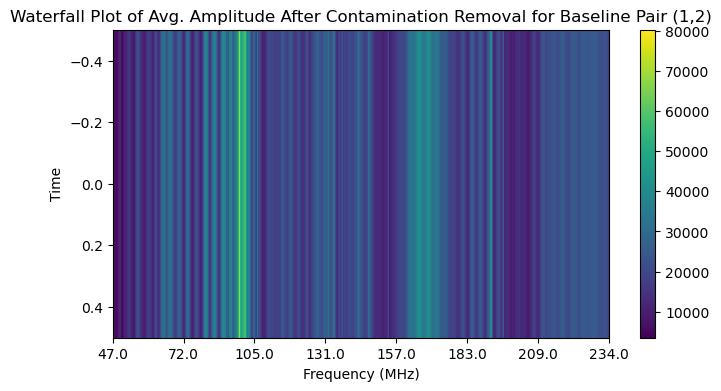

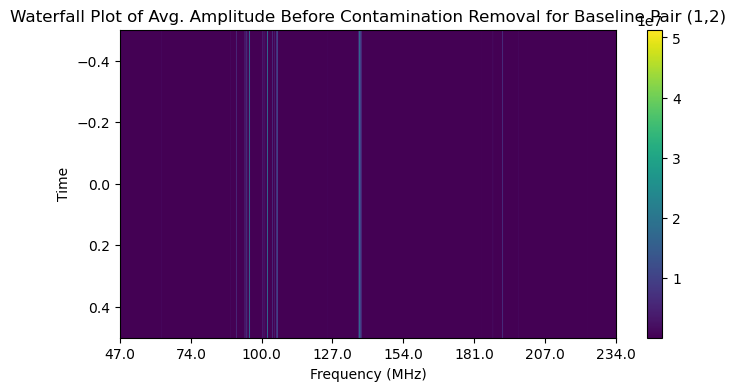

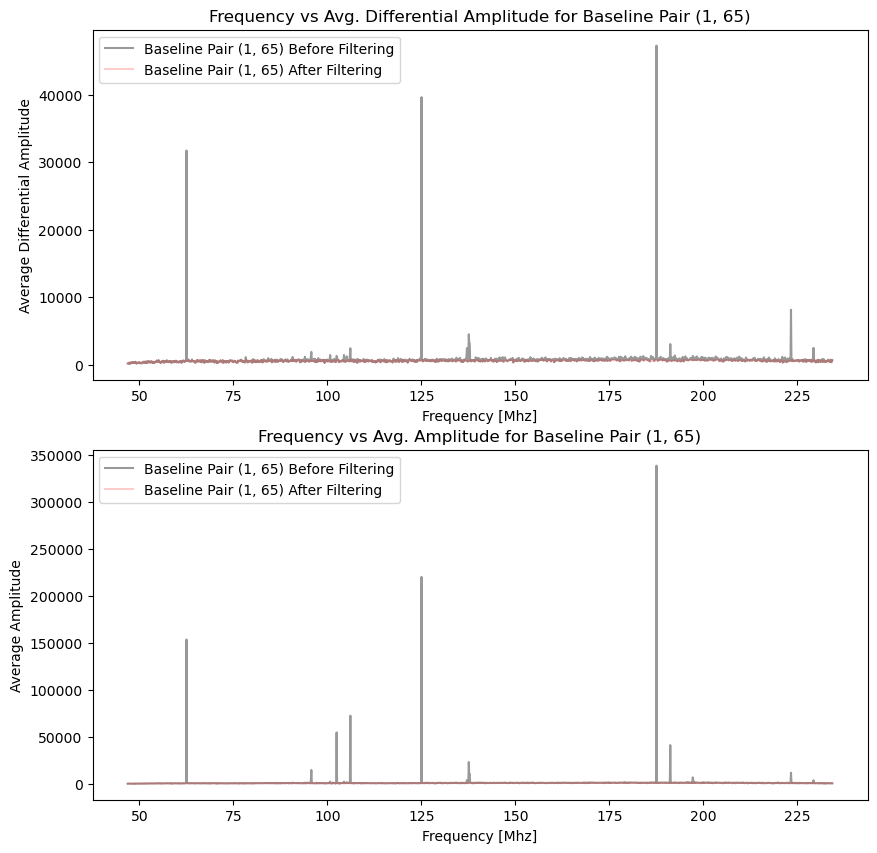

rejected (96,)
freqs shape: (1536,)
freqs_filtered shape: (1440,)
amplitudes_filtered shape: (20, 1440)
Threshold for baseline: -0.012


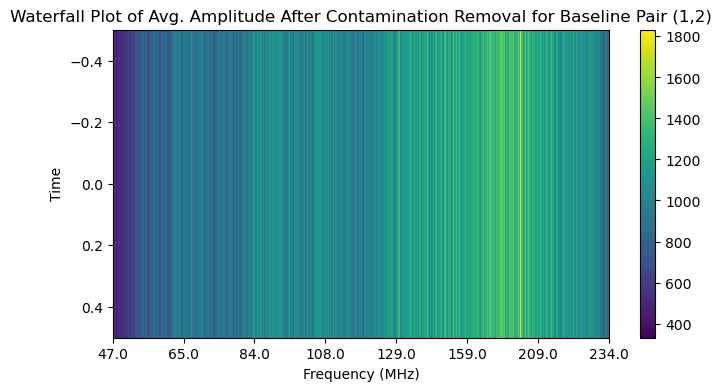

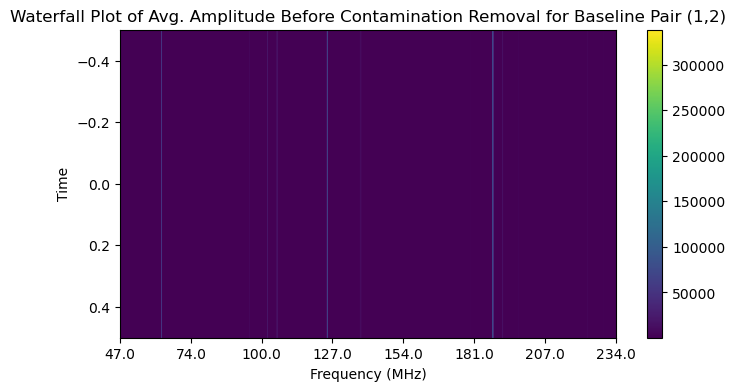

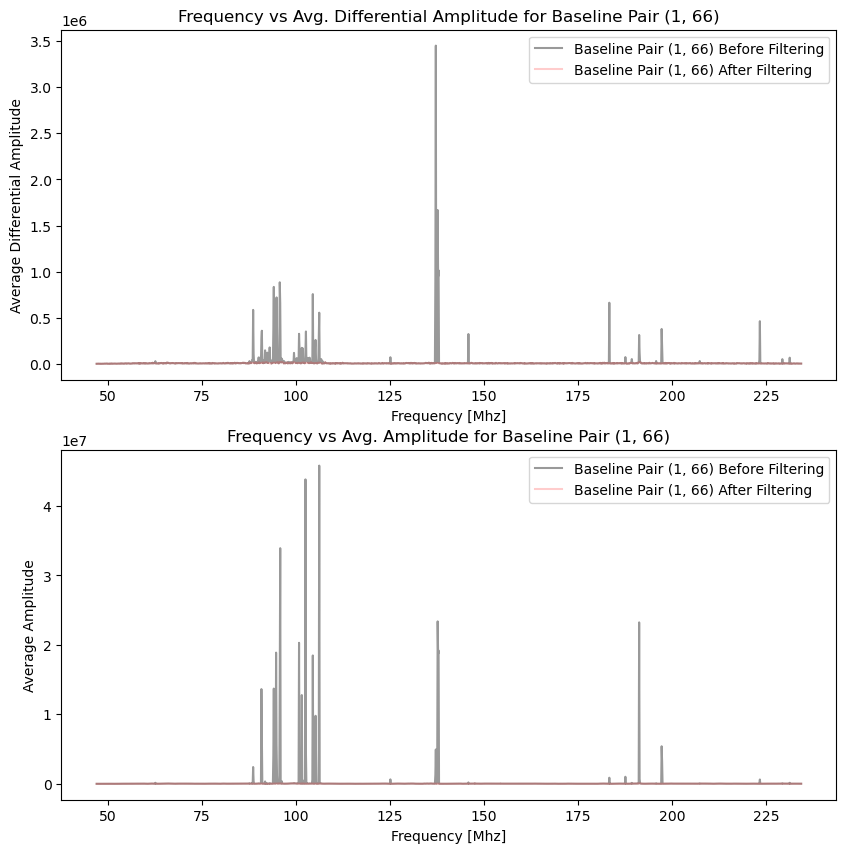

rejected (86,)
freqs shape: (1536,)
freqs_filtered shape: (1450,)
amplitudes_filtered shape: (20, 1450)
Threshold for baseline: -0.012


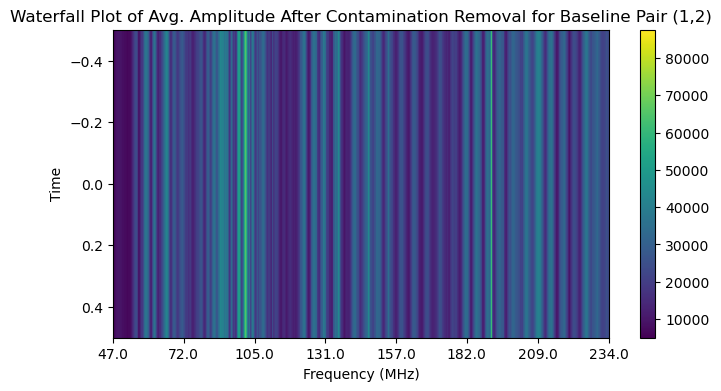

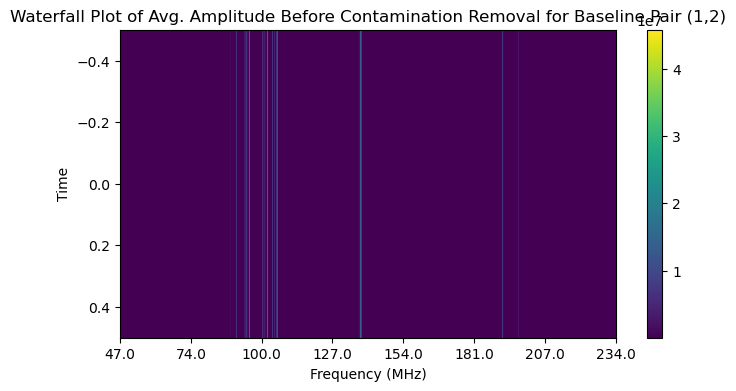

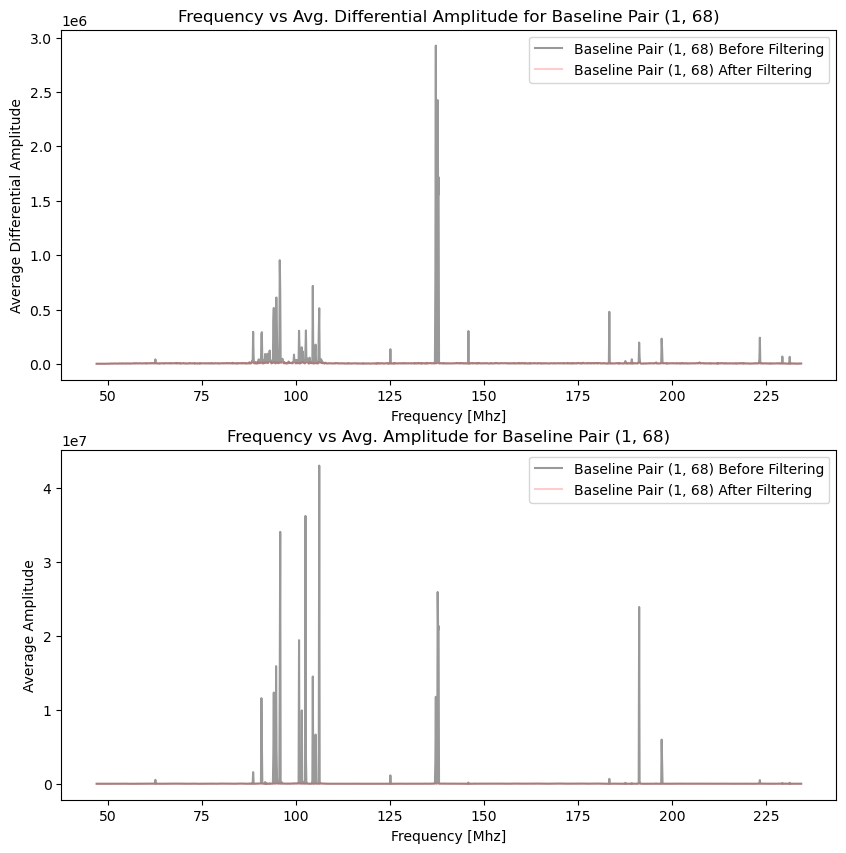

rejected (58,)
freqs shape: (1536,)
freqs_filtered shape: (1478,)
amplitudes_filtered shape: (20, 1478)
Threshold for baseline: -0.012


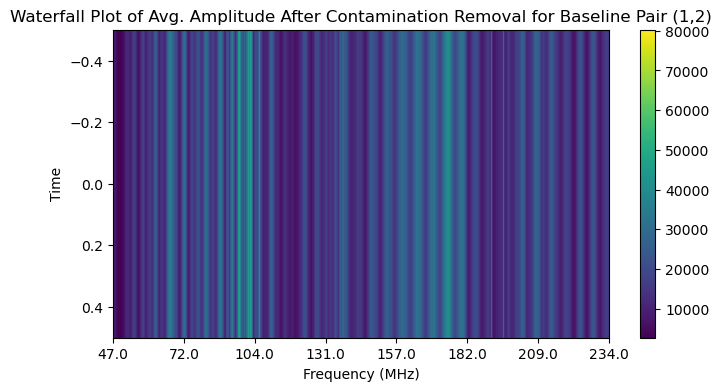

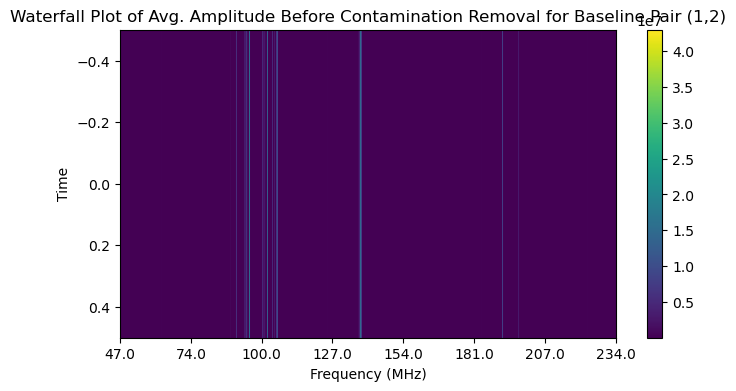

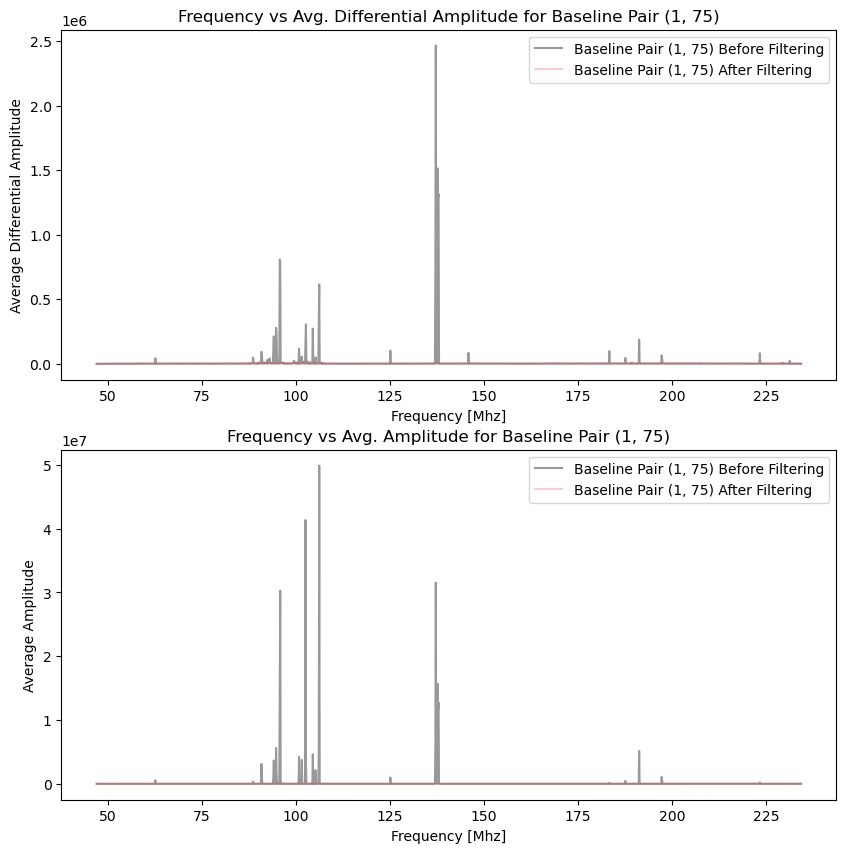

rejected (77,)
freqs shape: (1536,)
freqs_filtered shape: (1459,)
amplitudes_filtered shape: (20, 1459)
Threshold for baseline: -0.012


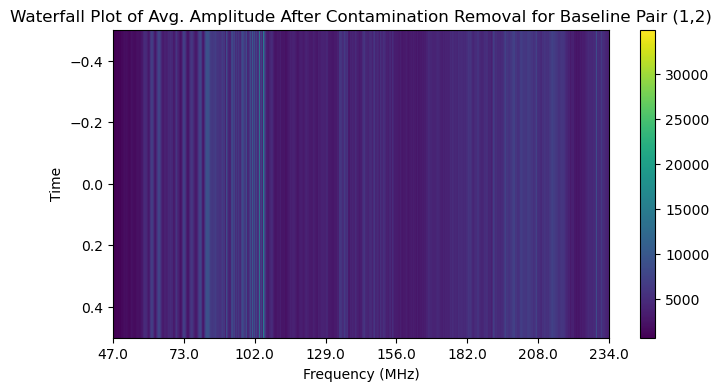

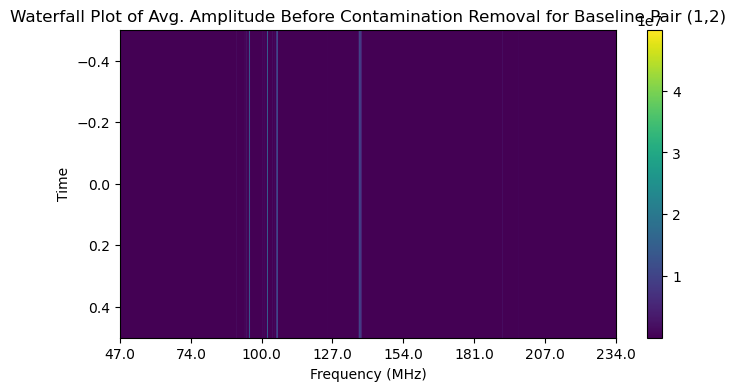

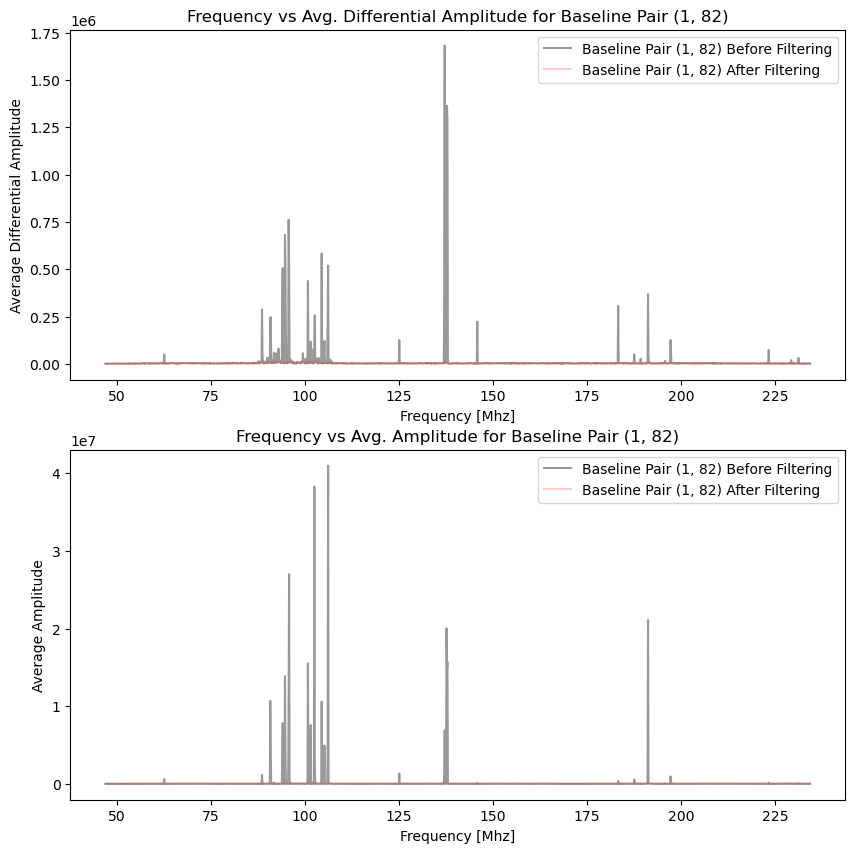

rejected (104,)
freqs shape: (1536,)
freqs_filtered shape: (1432,)
amplitudes_filtered shape: (20, 1432)
Threshold for baseline: -0.012


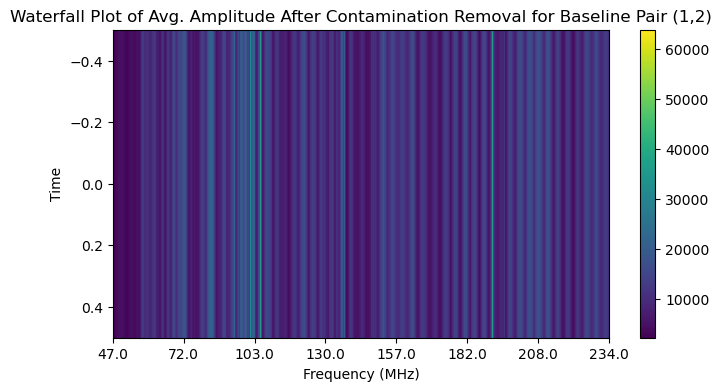

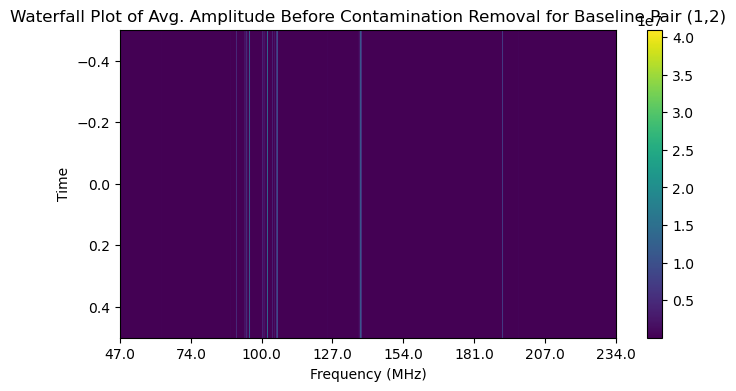

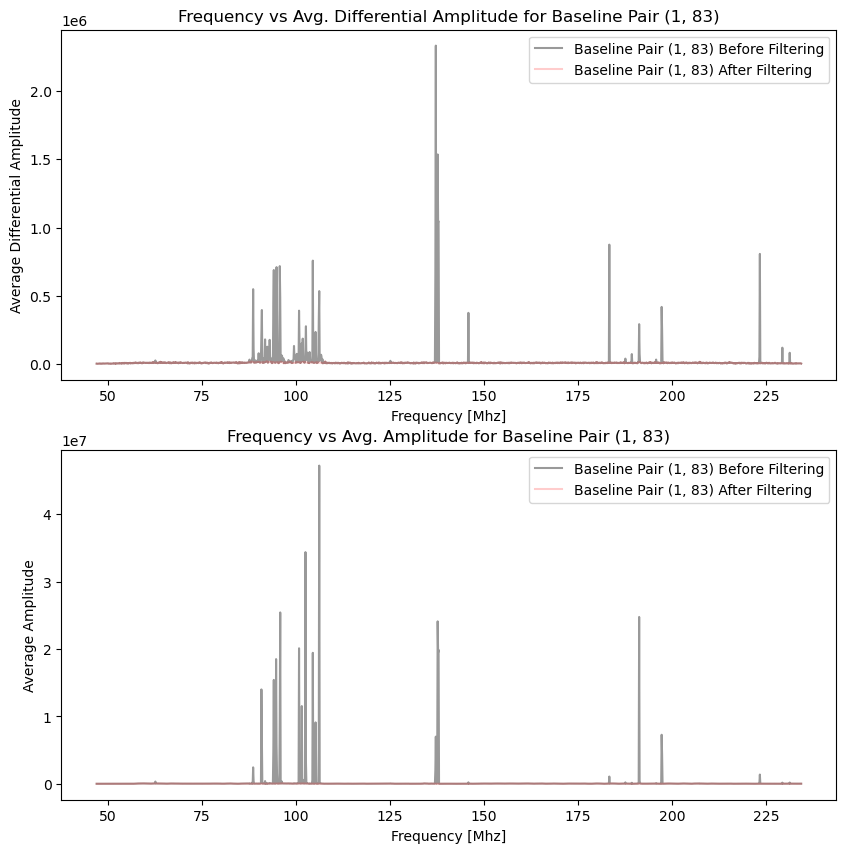

rejected (572,)
freqs shape: (1536,)
freqs_filtered shape: (964,)
amplitudes_filtered shape: (20, 964)
Threshold for baseline: -0.012


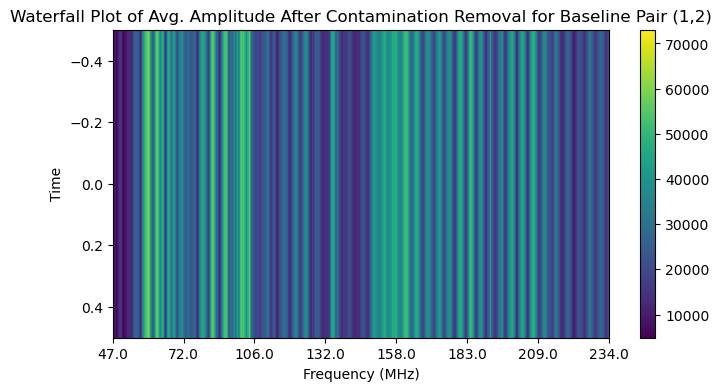

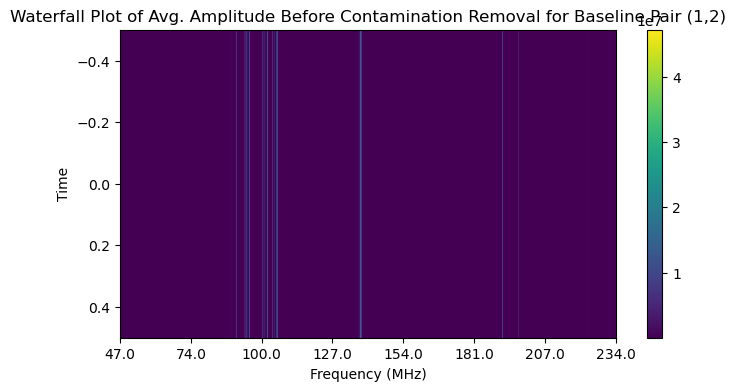

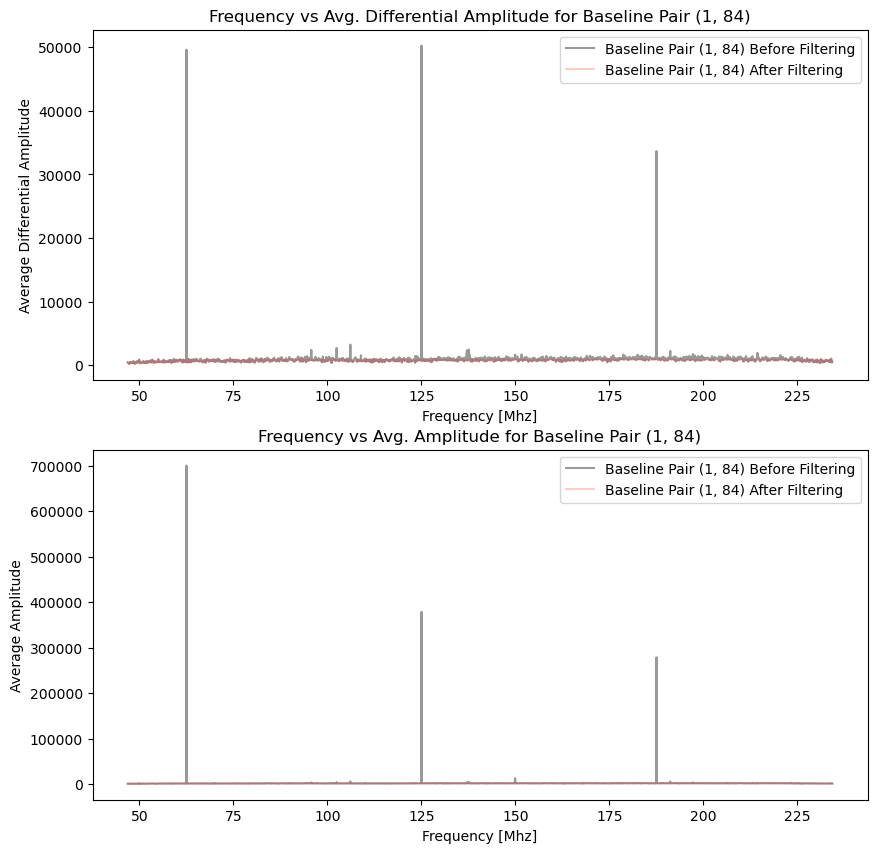

rejected (94,)
freqs shape: (1536,)
freqs_filtered shape: (1442,)
amplitudes_filtered shape: (20, 1442)
Threshold for baseline: -0.012


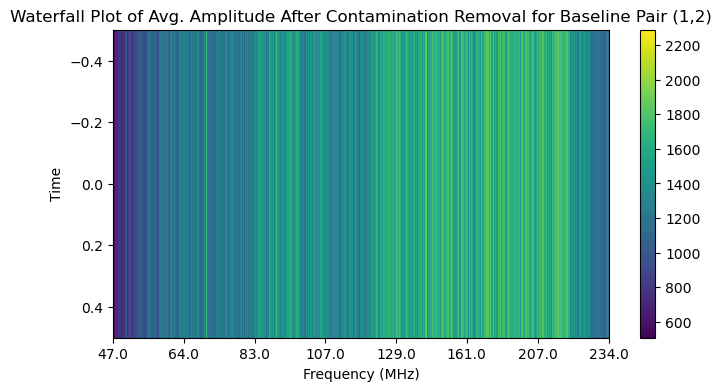

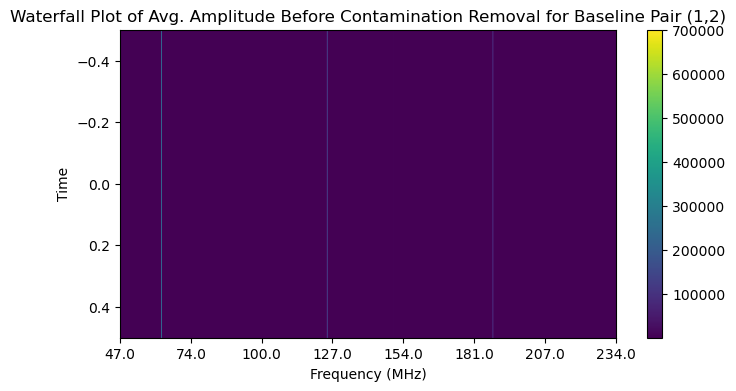

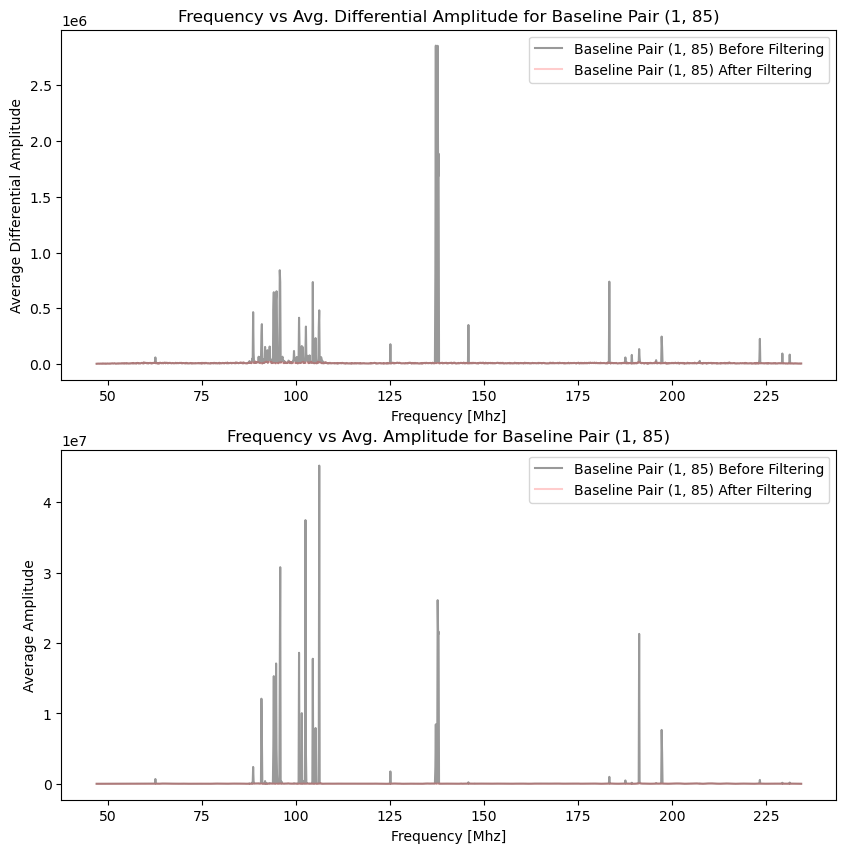

rejected (89,)
freqs shape: (1536,)
freqs_filtered shape: (1447,)
amplitudes_filtered shape: (20, 1447)
Threshold for baseline: -0.012


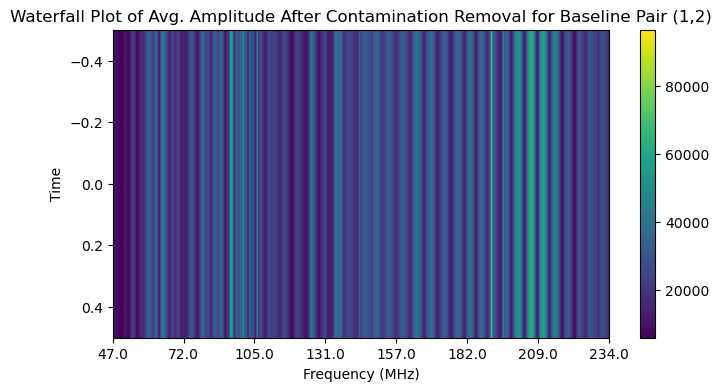

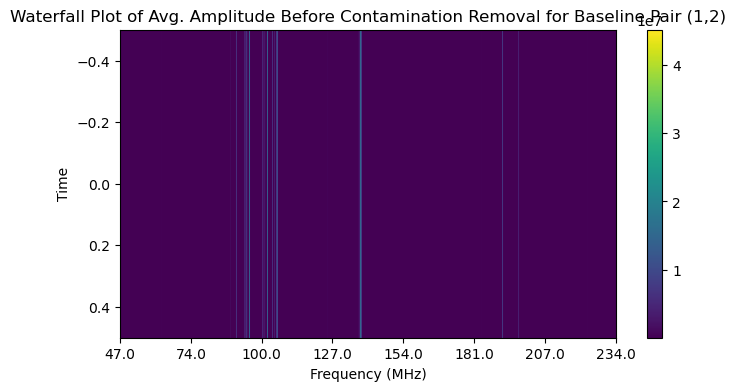

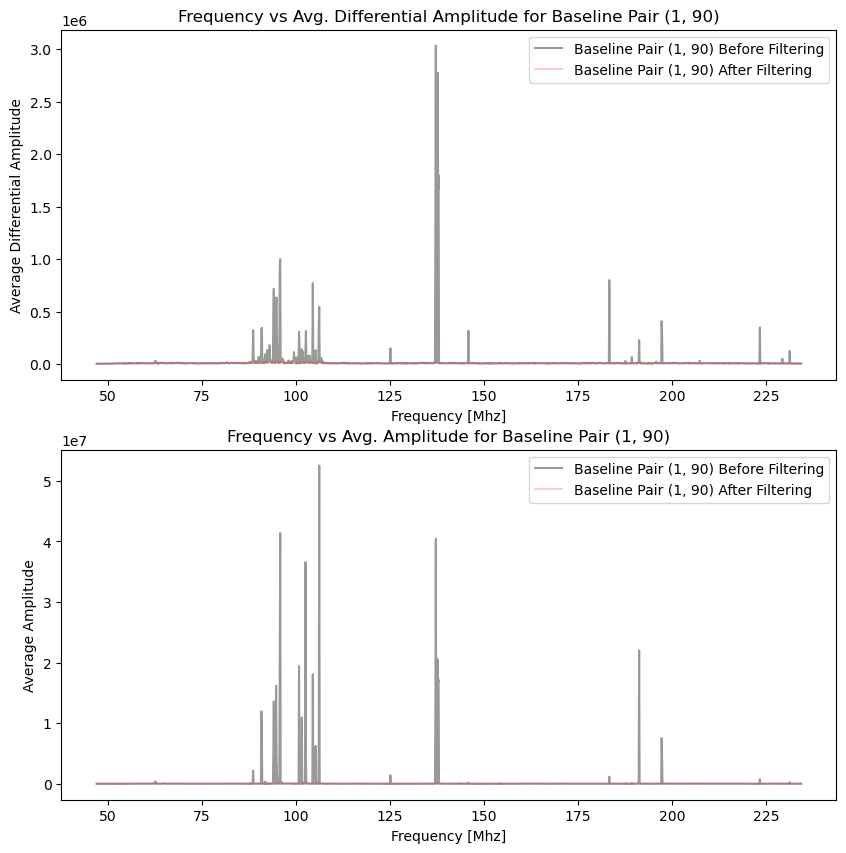

rejected (95,)
freqs shape: (1536,)
freqs_filtered shape: (1441,)
amplitudes_filtered shape: (20, 1441)
Threshold for baseline: -0.012


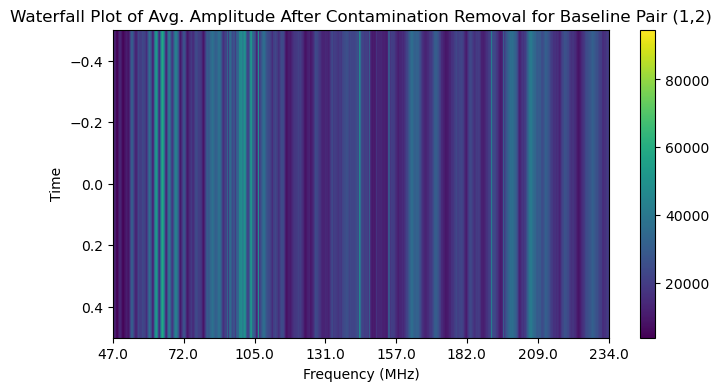

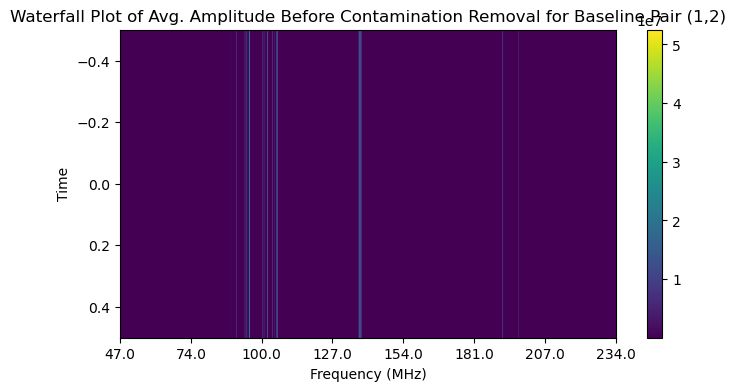

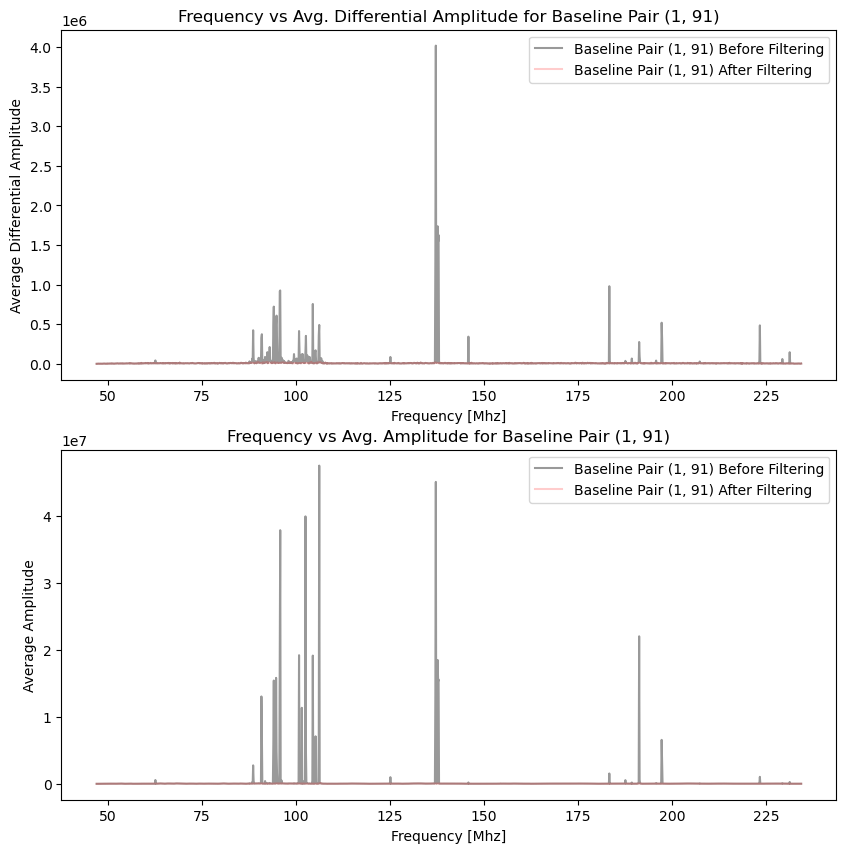

rejected (355,)
freqs shape: (1536,)
freqs_filtered shape: (1181,)
amplitudes_filtered shape: (20, 1181)
Threshold for baseline: -0.012


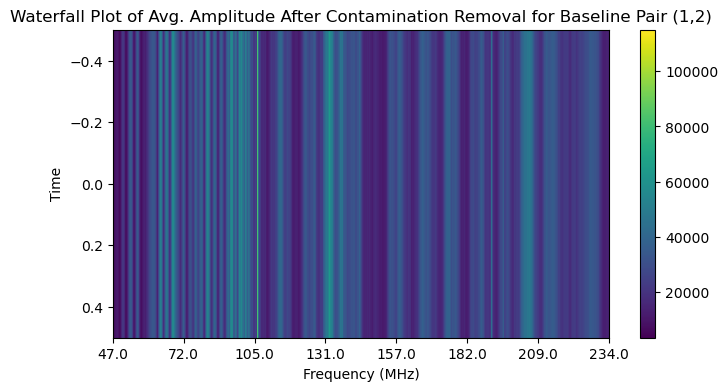

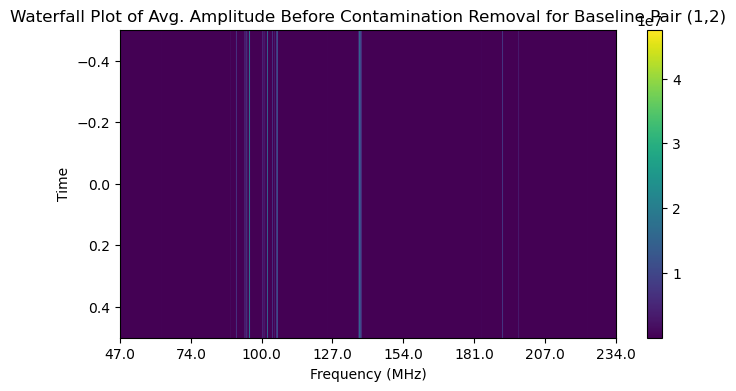

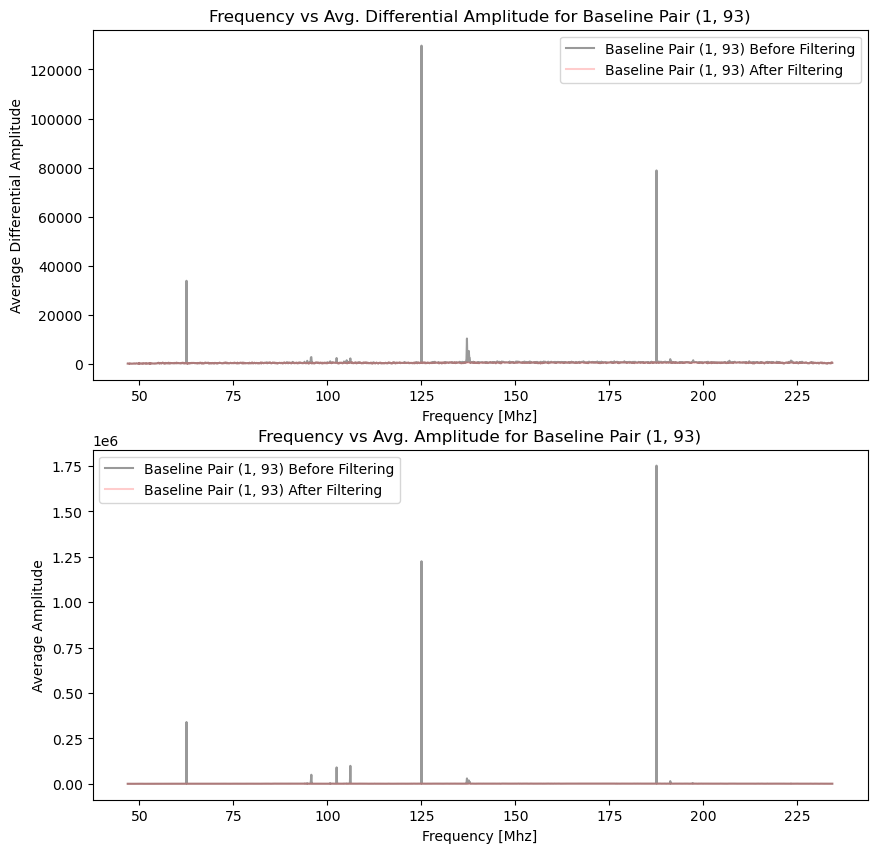

rejected (97,)
freqs shape: (1536,)
freqs_filtered shape: (1439,)
amplitudes_filtered shape: (20, 1439)
Threshold for baseline: -0.012


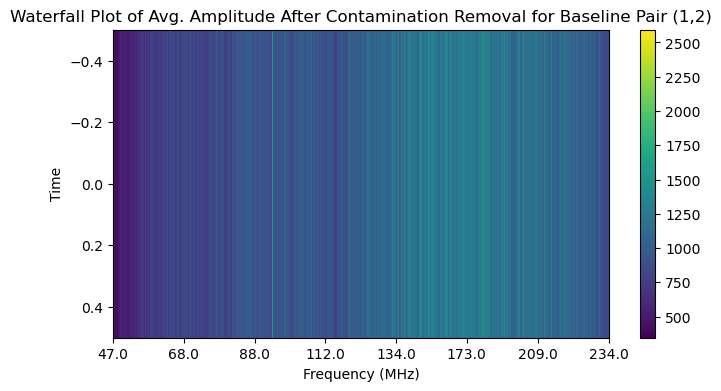

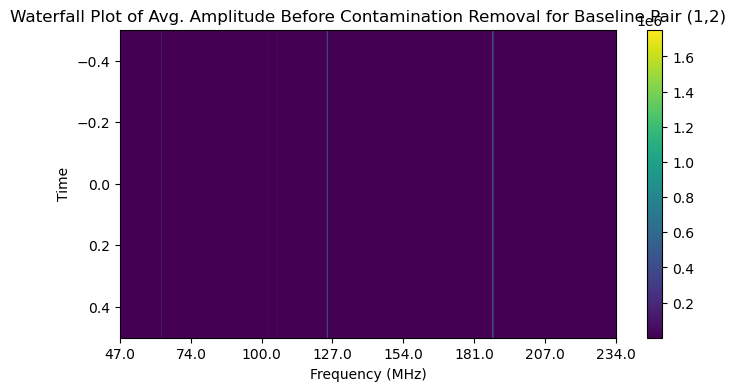

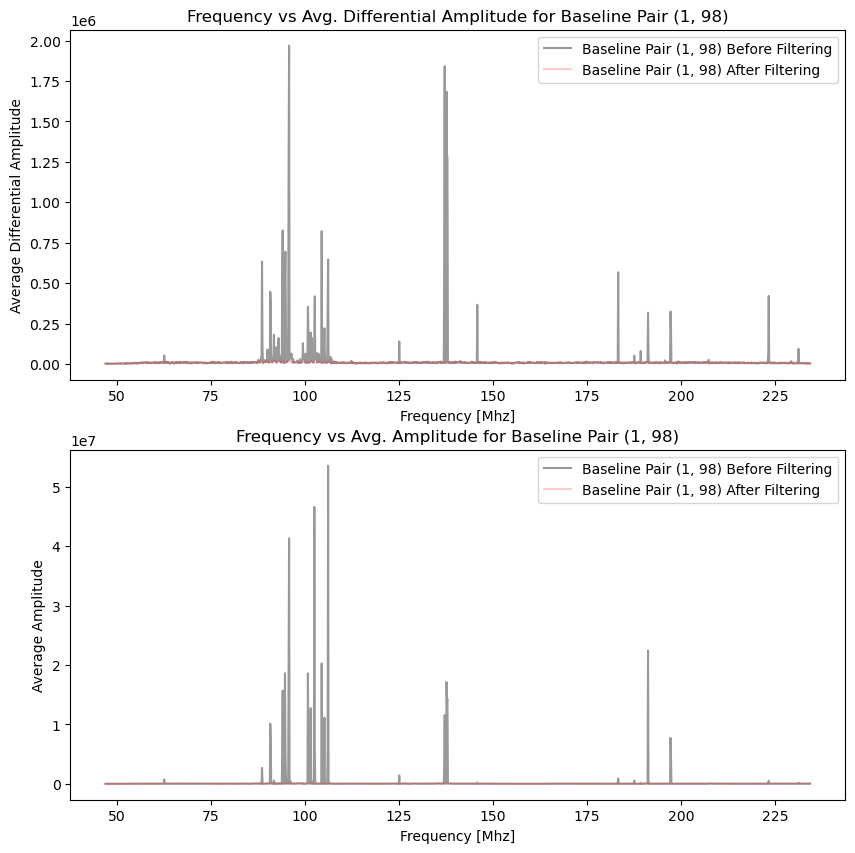

rejected (99,)
freqs shape: (1536,)
freqs_filtered shape: (1437,)
amplitudes_filtered shape: (20, 1437)
Threshold for baseline: -0.012


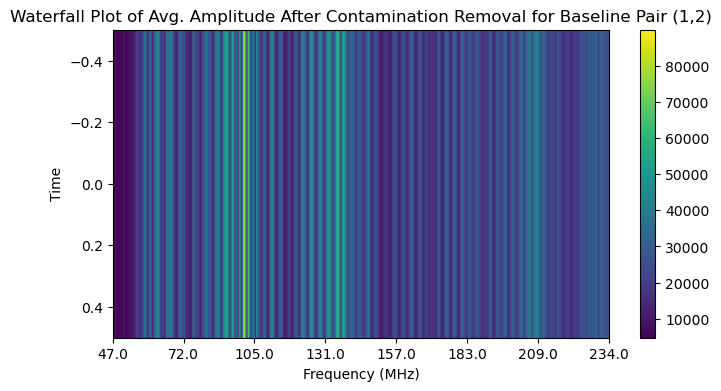

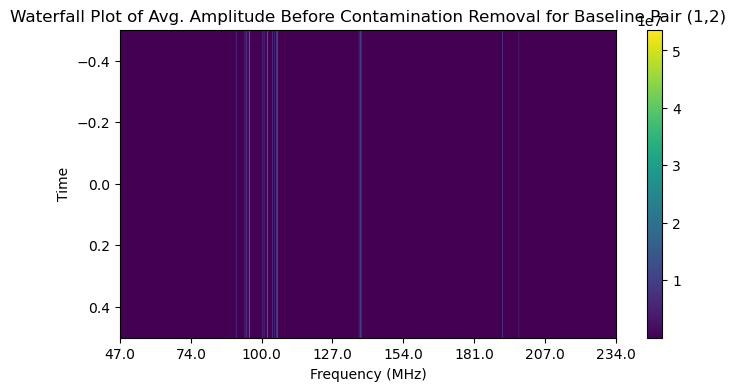

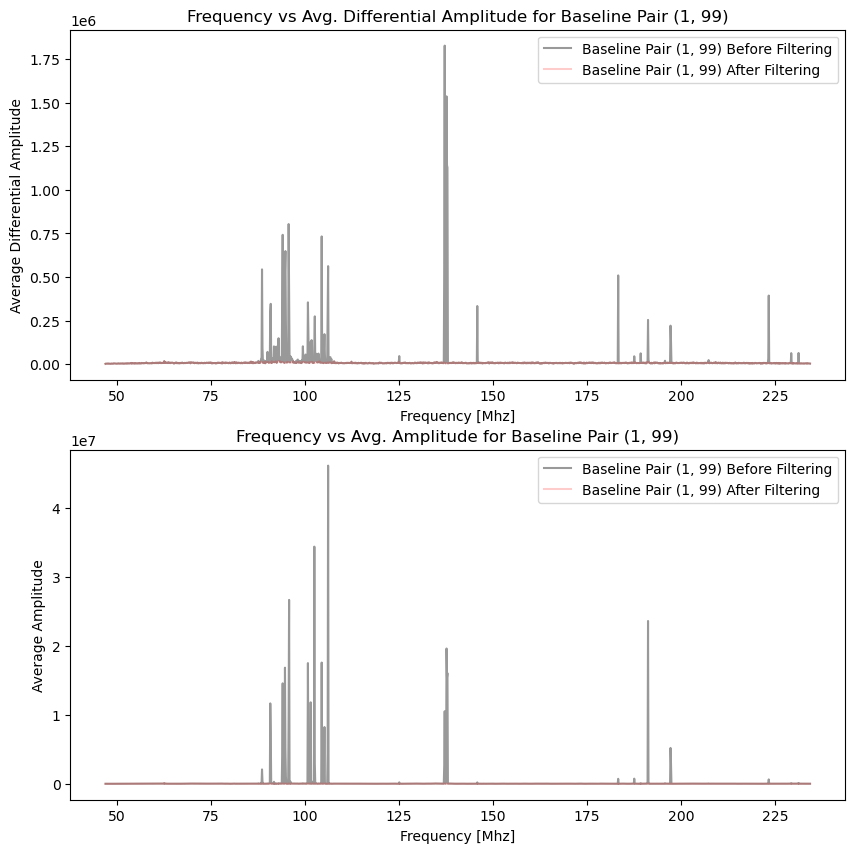

rejected (92,)
freqs shape: (1536,)
freqs_filtered shape: (1444,)
amplitudes_filtered shape: (20, 1444)
Threshold for baseline: -0.012


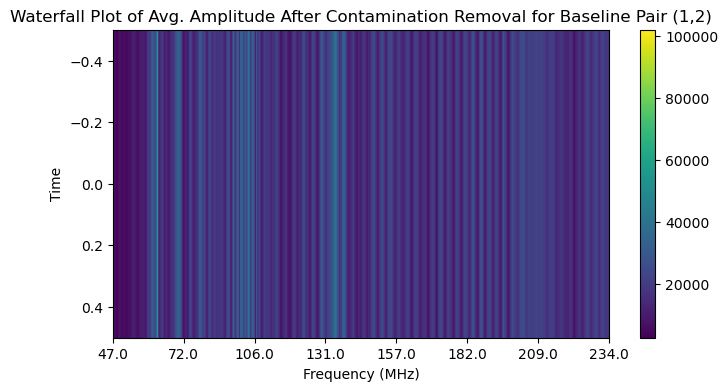

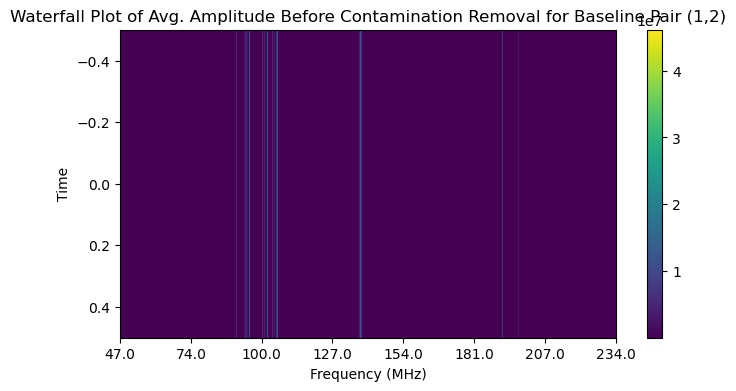

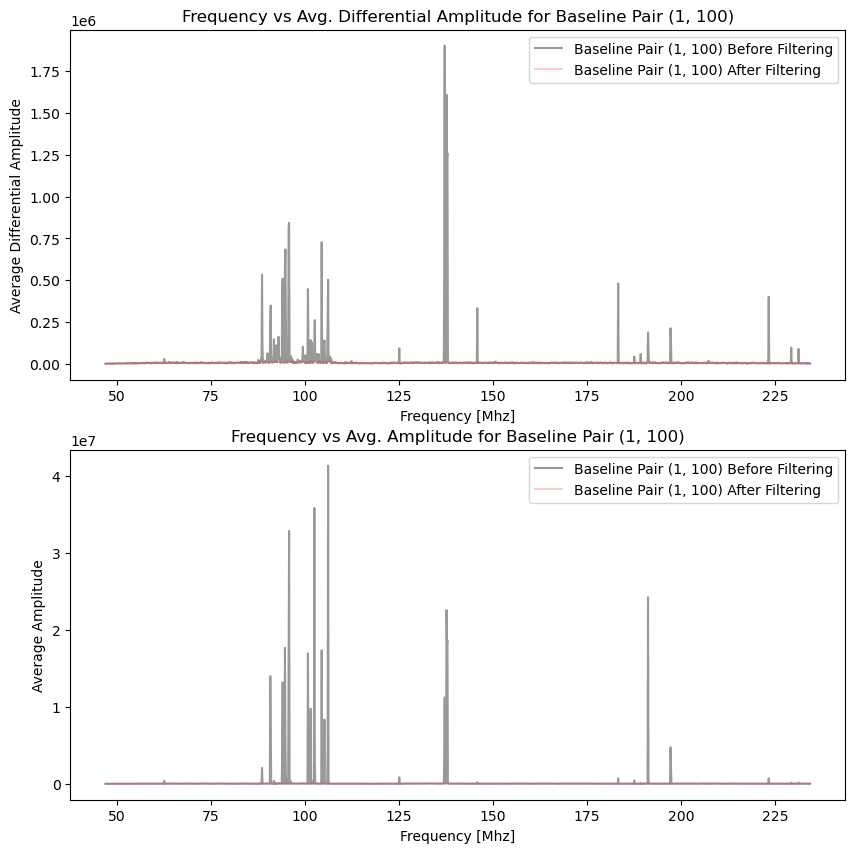

rejected (100,)
freqs shape: (1536,)
freqs_filtered shape: (1436,)
amplitudes_filtered shape: (20, 1436)
Threshold for baseline: -0.012


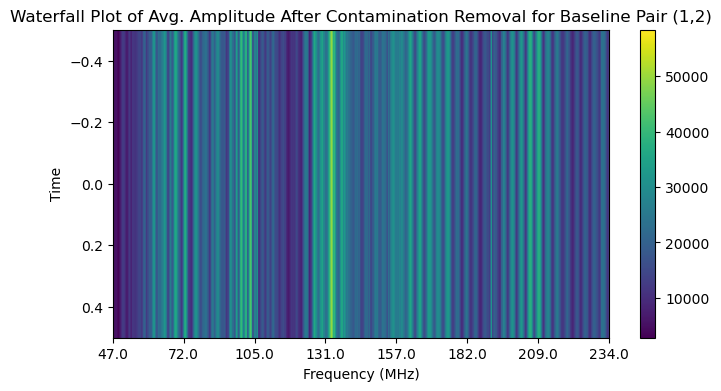

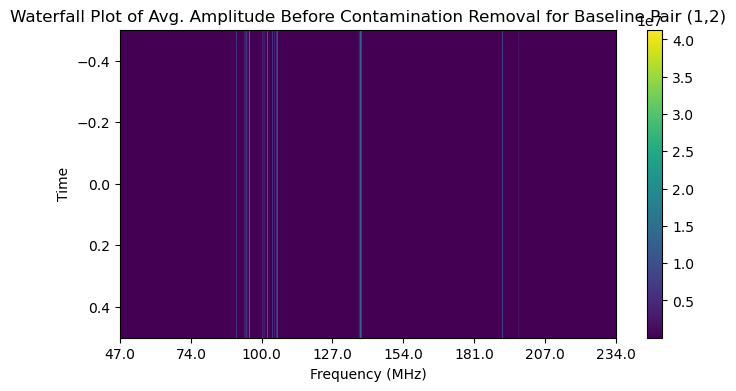

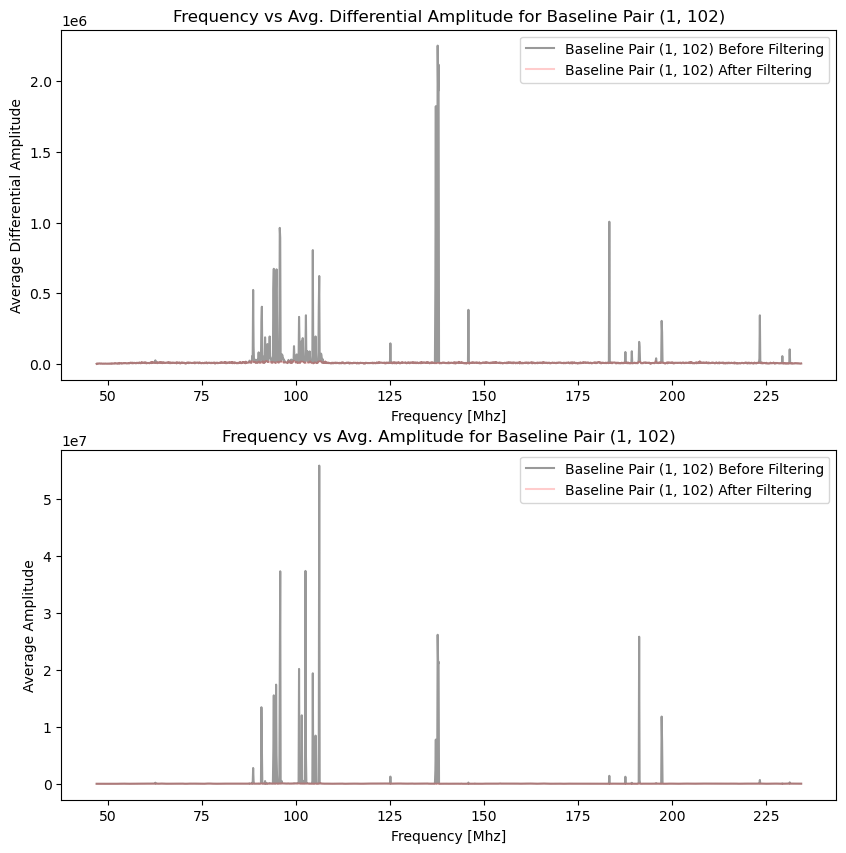

rejected (94,)
freqs shape: (1536,)
freqs_filtered shape: (1442,)
amplitudes_filtered shape: (20, 1442)
Threshold for baseline: -0.012


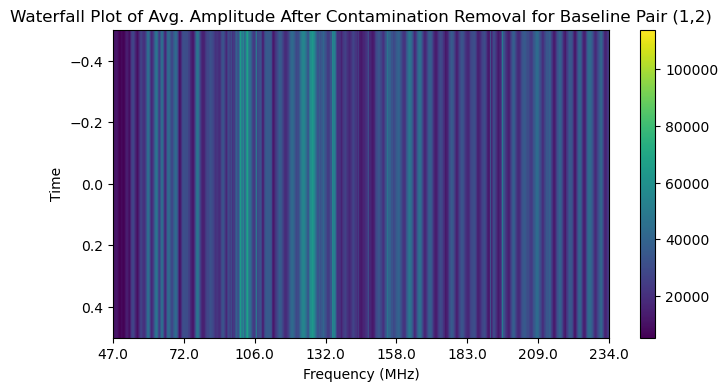

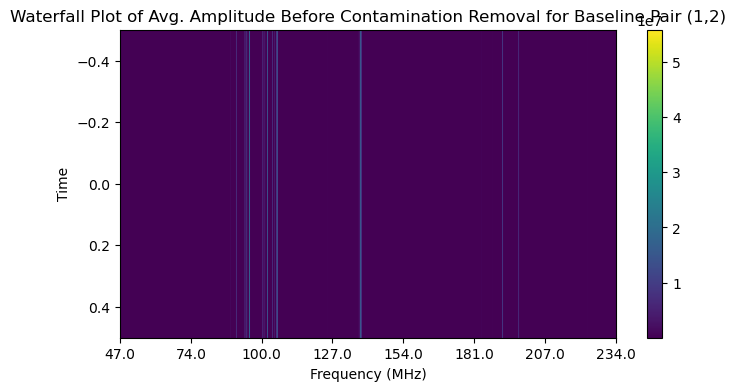

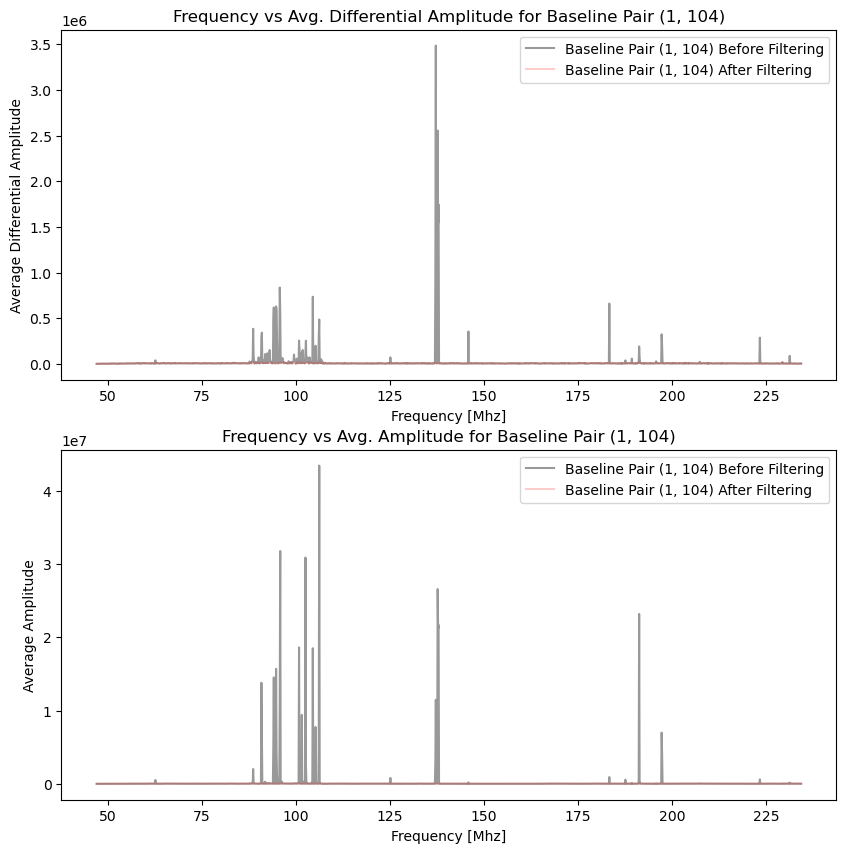

rejected (103,)
freqs shape: (1536,)
freqs_filtered shape: (1433,)
amplitudes_filtered shape: (20, 1433)
Threshold for baseline: -0.012


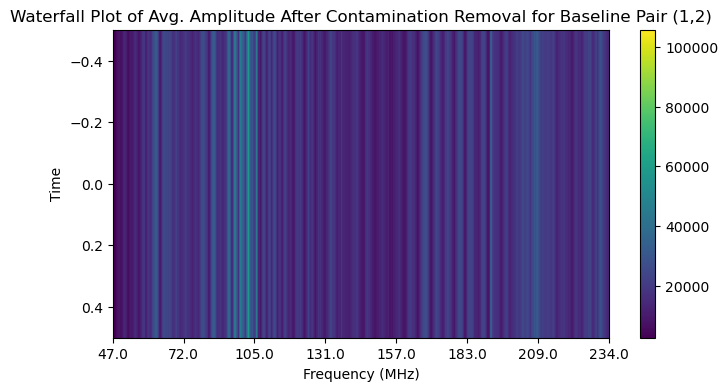

KeyboardInterrupt: 

In [90]:
n = filter(uv)